In [59]:
import numpy as np 
import pandas as pd 
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv("data/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
dataset['Date'] = pd.to_datetime(dataset['Date'], format = '%Y-%m-%d')
dataset.head()

,Store,Dept,Date,weeklySales,isHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
dataset.describe()

,Store,Dept,weeklySales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [4]:
dataset.shape

(421570, 5)

In [5]:
# train data period
print(dataset['Date'].min(), dataset['Date'].max())

2010-02-05 00:00:00 2012-10-26 00:00:00


In [6]:
test_dataset = pd.read_csv("data/test.csv", names=['Store','Dept','Date','isHoliday'], sep=',', header=0)
test_dataset['Date'] = pd.to_datetime(test_dataset['Date'], format = '%Y-%m-%d')
test_dataset.head()

,Store,Dept,Date,isHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [7]:
# test data period
print(test_dataset['Date'].min(), test_dataset['Date'].max())

2012-11-02 00:00:00 2013-07-26 00:00:00


In [8]:
stores = pd.read_csv("data/stores.csv", names=['Store','Type','Size'],sep=',', header=0)

In [9]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [10]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [11]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [12]:
stores['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [13]:
dataset['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [14]:
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [15]:
grouped=stores.groupby('Type')
print(grouped.describe()['Size'].round(2))

      count       mean       std      min        25%       50%       75%  \
Type                                                                       
A      22.0  177247.73  49392.62  39690.0  155840.75  202406.0  203819.0   
B      17.0  101190.71  32371.14  34875.0   93188.00  114533.0  123737.0   
C       6.0   40541.67   1304.15  39690.0   39745.00   39910.0   40774.0   

           max  
Type            
A     219622.0  
B     140167.0  
C      42988.0  


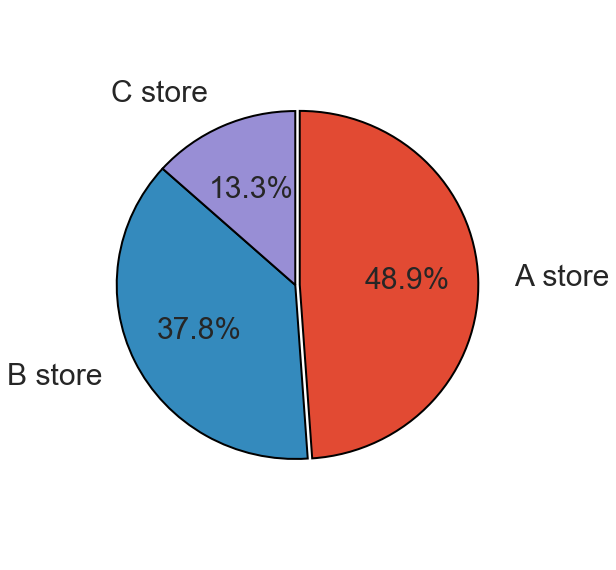

In [16]:
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=grouped.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion


fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}


axes.pie(sizes,
        labels=labels,
        explode=(0.02,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        counterclock=False, startangle=90)
plt.show()

In [17]:
features = pd.read_csv("data/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','isHoliday'])
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,isHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [18]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [19]:
features_wo_holiday = features.drop(columns=['isHoliday'])
features_wo_holiday['Date'] = pd.to_datetime(features_wo_holiday['Date'], format = '%Y-%m-%d')
features['Date'] = pd.to_datetime(features['Date'], format = '%Y-%m-%d')

In [20]:
dataset = dataset.merge(stores, how='left').merge(features, how='left')
dataset.head()

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [21]:
dataset.describe()
# Markdown2, Markdown3 & Markdown5 have negative values, 
# which need to be replaced by 0

,Store,Dept,weeklySales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [22]:
test_dataset = test_dataset.merge(stores, how='left').merge(features, how='left')
test_dataset.head()

,Store,Dept,Date,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


In [23]:
# Convert negative values to zero
dataset.loc[dataset['weeklySales'] < 0.0,'weeklySales'] = 0.0
dataset.loc[dataset['MarkDown2'] < 0.0,'MarkDown2'] = 0.0
dataset.loc[dataset['MarkDown3'] < 0.0,'MarkDown3'] = 0.0
test_dataset.loc[test_dataset['MarkDown1'] < 0.0,'MarkDown1'] = 0.0
test_dataset.loc[test_dataset['MarkDown2'] < 0.0,'MarkDown2'] = 0.0
test_dataset.loc[test_dataset['MarkDown3'] < 0.0,'MarkDown3'] = 0.0
test_dataset.loc[test_dataset['MarkDown5'] < 0.0,'MarkDown5'] = 0.0

In [24]:
# Check for count of missing values 
print(dataset.isnull().sum())

Store                0
Dept                 0
Date                 0
weeklySales          0
isHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


In [25]:
print(test_dataset.isnull().sum())

Store               0
Dept                0
Date                0
isHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


/Users/takasato/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "higher right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


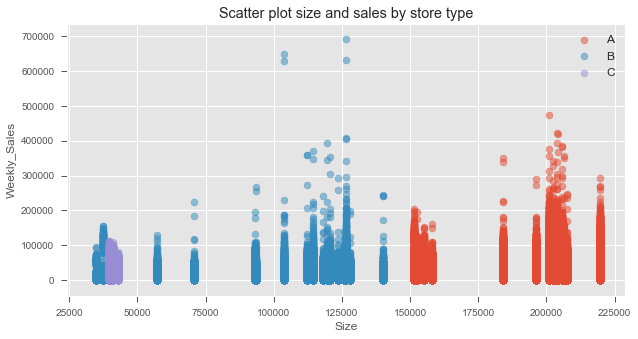

In [26]:
types=stores['Type'].unique()

plt.style.use('ggplot')

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

for t in types:
    x=dataset.loc[dataset['Type']==t, 'Size']
    y=dataset.loc[dataset['Type']==t, 'weeklySales']
    
    ax.scatter(x,y,alpha=0.5, label=t)

ax.set_title('Scatter plot size and sales by store type')
ax.set_xlabel('Size')
ax.set_ylabel('Weekly_Sales')

ax.legend(loc='higher right',fontsize=12)

plt.show()

In [27]:
# Convert NaN to zero
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month

test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
test_dataset['Month'] = pd.to_datetime(test_dataset['Date']).dt.month


In [28]:
# Converted Date(yyyy-mm-dd format) to "year", "month", "week", and "day".
# Add cumulative week count "n_days" since there is an upward trend in the series
# Store data is categorical, so I used One-Hot encoding

dataset_time=dataset
test_dataset_time=test_dataset

dataset_time['Year']=dataset_time['Date'].dt.year
dataset_time['Month']=dataset_time['Date'].dt.month
dataset_time['Week']=dataset_time['Date'].dt.week
dataset_time['Day']=dataset_time['Date'].dt.day
dataset_time['n_days']=(dataset_time['Date'].dt.date-dataset_time['Date'].dt.date.min()).apply(lambda x:x.days)

test_dataset_time['Year']=test_dataset_time['Date'].dt.year
test_dataset_time['Month']=test_dataset_time['Date'].dt.month
test_dataset_time['Week']=test_dataset_time['Date'].dt.week
test_dataset_time['Day']=test_dataset_time['Date'].dt.day
test_dataset_time['n_days']=(test_dataset_time['Date'].dt.date-dataset_time['Date'].dt.date.min()).apply(lambda x:x.days)

Year=pd.Series(dataset_time['Year'].unique())
Week=pd.Series(dataset_time['Week'].unique())
Month=pd.Series(dataset_time['Month'].unique())
Day=pd.Series(dataset_time['Day'].unique())
n_days=pd.Series(dataset_time['n_days'].unique())

dataset_time = pd.get_dummies(dataset_time, columns=["Type"])

(11090, 20)
   Dept       Date  Store  weeklySales  isHoliday      Size  Temperature  \
0     1 2010-02-05   23.0      19596.0      False  130288.0         34.0   
1     1 2010-02-12   23.0      32382.0       True  130288.0         34.0   
2     1 2010-02-19   23.0      24850.0      False  130288.0         38.0   
3     1 2010-02-26   23.0      15142.0      False  130288.0         39.0   
4     1 2010-03-05   23.0      16948.0      False  130288.0         43.0   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5    CPI  \
0         3.0        0.0        0.0        0.0        0.0        0.0  168.0   
1         3.0        0.0        0.0        0.0        0.0        0.0  168.0   
2         3.0        0.0        0.0        0.0        0.0        0.0  168.0   
3         3.0        0.0        0.0        0.0        0.0        0.0  168.0   
4         3.0        0.0        0.0        0.0        0.0        0.0  168.0   

   Unemployment  Month    Year  Week   Day  n_days  
0  

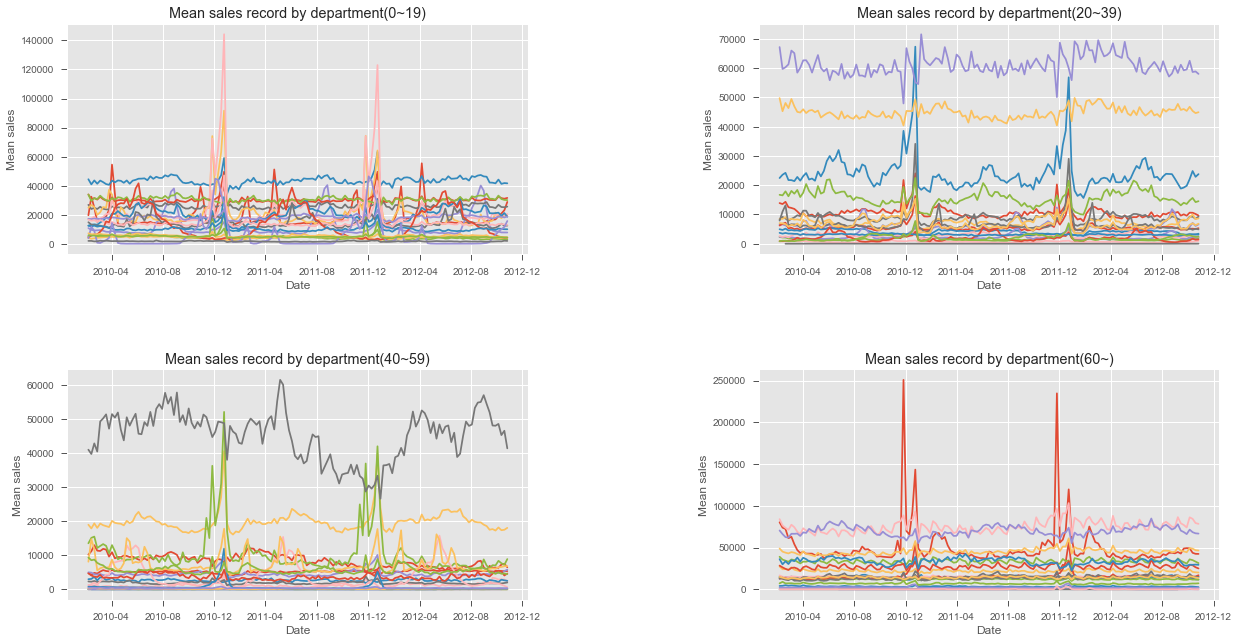

In [29]:
# Sales by department

grouped=dataset.groupby(['Dept','Date']).mean().round(0).reset_index()
print(grouped.shape)
print(grouped.head())
data=grouped[['Dept','Date','weeklySales']]


dept=dataset['Dept'].unique()
dept.sort()
dept_1=dept[0:20]
dept_2=dept[20:40]
dept_3=dept[40:60]
dept_4=dept[60:]

fig, ax = plt.subplots(2,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for i in dept_1 :
    data_1=data[data['Dept']==i]
    ax[0,0].plot(data_1['Date'], data_1['weeklySales'],label='Dept_1_mean_sales')

for i in dept_2 :
    data_1=data[data['Dept']==i]
    ax[0,1].plot(data_1['Date'], data_1['weeklySales'],label='Dept_1_mean_sales')
    
for i in dept_3 :
    data_1=data[data['Dept']==i]
    ax[1,0].plot(data_1['Date'], data_1['weeklySales'],label='Dept_1_mean_sales')    

for i in dept_4 :
    data_1=data[data['Dept']==i]
    ax[1,1].plot(data_1['Date'], data_1['weeklySales'],label='Dept_1_mean_sales')        
    
ax[0,0].set_title('Mean sales record by department(0~19)')
ax[0,1].set_title('Mean sales record by department(20~39)')
ax[1,0].set_title('Mean sales record by department(40~59)')
ax[1,1].set_title('Mean sales record by department(60~)')


ax[0,0].set_ylabel('Mean sales')
ax[0,0].set_xlabel('Date')
ax[0,1].set_ylabel('Mean sales')
ax[0,1].set_xlabel('Date')
ax[1,0].set_ylabel('Mean sales')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Mean sales')
ax[1,1].set_xlabel('Date')


plt.show()

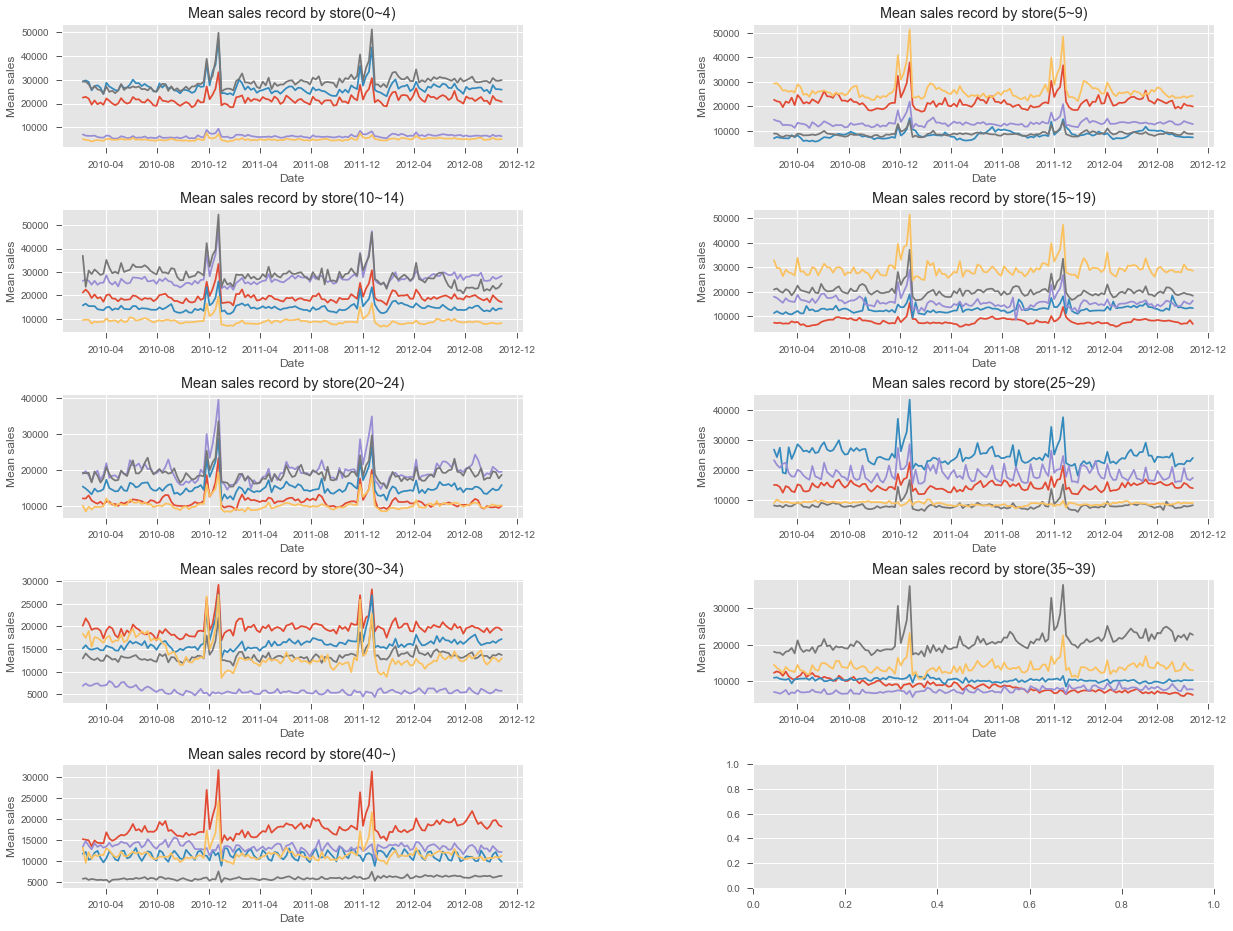

In [30]:
# Sales by store

grouped=dataset.groupby(['Store','Date']).mean().round(0).reset_index()
grouped.shape
grouped.head()

data=grouped[['Store','Date','weeklySales']]
type(data)


store=dataset['Store'].unique()
store.sort()
store_1=store[0:5]
store_2=store[5:10]
store_3=store[10:15]
store_4=store[15:20]
store_5=store[20:25]
store_6=store[25:30]
store_7=store[30:35]
store_8=store[35:40]
store_9=store[40:]

fig, ax = plt.subplots(5,2,figsize=(20,15))

fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for i in store_1 :
    data_1=data[data['Store']==i]
    ax[0,0].plot(data_1['Date'], data_1['weeklySales'])
    
for i in store_2 :
    data_2=data[data['Store']==i]
    ax[0,1].plot(data_2['Date'], data_2['weeklySales'])
    
for i in store_3 :
    data_3=data[data['Store']==i]
    ax[1,0].plot(data_3['Date'], data_3['weeklySales'])

for i in store_4 :
    data_4=data[data['Store']==i]
    ax[1,1].plot(data_4['Date'], data_4['weeklySales'])
    
for i in store_5 :
    data_5=data[data['Store']==i]
    ax[2,0].plot(data_5['Date'], data_5['weeklySales'])  

for i in store_6 :
    data_6=data[data['Store']==i]
    ax[2,1].plot(data_6['Date'], data_6['weeklySales'])  

for i in store_7 :
    data_7=data[data['Store']==i]
    ax[3,0].plot(data_7['Date'], data_7['weeklySales'])

for i in store_8 :
    data_8=data[data['Store']==i]
    ax[3,1].plot(data_8['Date'], data_8['weeklySales'])     
    
for i in store_9 :
    data_9=data[data['Store']==i]
    ax[4,0].plot(data_9['Date'], data_9['weeklySales'])     

    
ax[0,0].set_title('Mean sales record by store(0~4)')
ax[0,1].set_title('Mean sales record by store(5~9)')
ax[1,0].set_title('Mean sales record by store(10~14)')
ax[1,1].set_title('Mean sales record by store(15~19)')
ax[2,0].set_title('Mean sales record by store(20~24)')
ax[2,1].set_title('Mean sales record by store(25~29)')
ax[3,0].set_title('Mean sales record by store(30~34)')
ax[3,1].set_title('Mean sales record by store(35~39)')
ax[4,0].set_title('Mean sales record by store(40~)')


ax[0,0].set_ylabel('Mean sales')
ax[0,0].set_xlabel('Date')
ax[0,1].set_ylabel('Mean sales')
ax[0,1].set_xlabel('Date')
ax[1,0].set_ylabel('Mean sales')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Mean sales')
ax[1,1].set_xlabel('Date')
ax[2,0].set_ylabel('Mean sales')
ax[2,0].set_xlabel('Date')
ax[2,1].set_ylabel('Mean sales')
ax[2,1].set_xlabel('Date')
ax[3,0].set_ylabel('Mean sales')
ax[3,0].set_xlabel('Date')
ax[3,1].set_ylabel('Mean sales')
ax[3,1].set_xlabel('Date')
ax[4,0].set_ylabel('Mean sales')
ax[4,0].set_xlabel('Date')



plt.show()

In [31]:
ttl_ts = dataset.groupby('Date')['weeklySales'].sum().reset_index()
ttl_ts = ttl_ts.set_index('Date')
ttl_ts.index.name = 'Date'

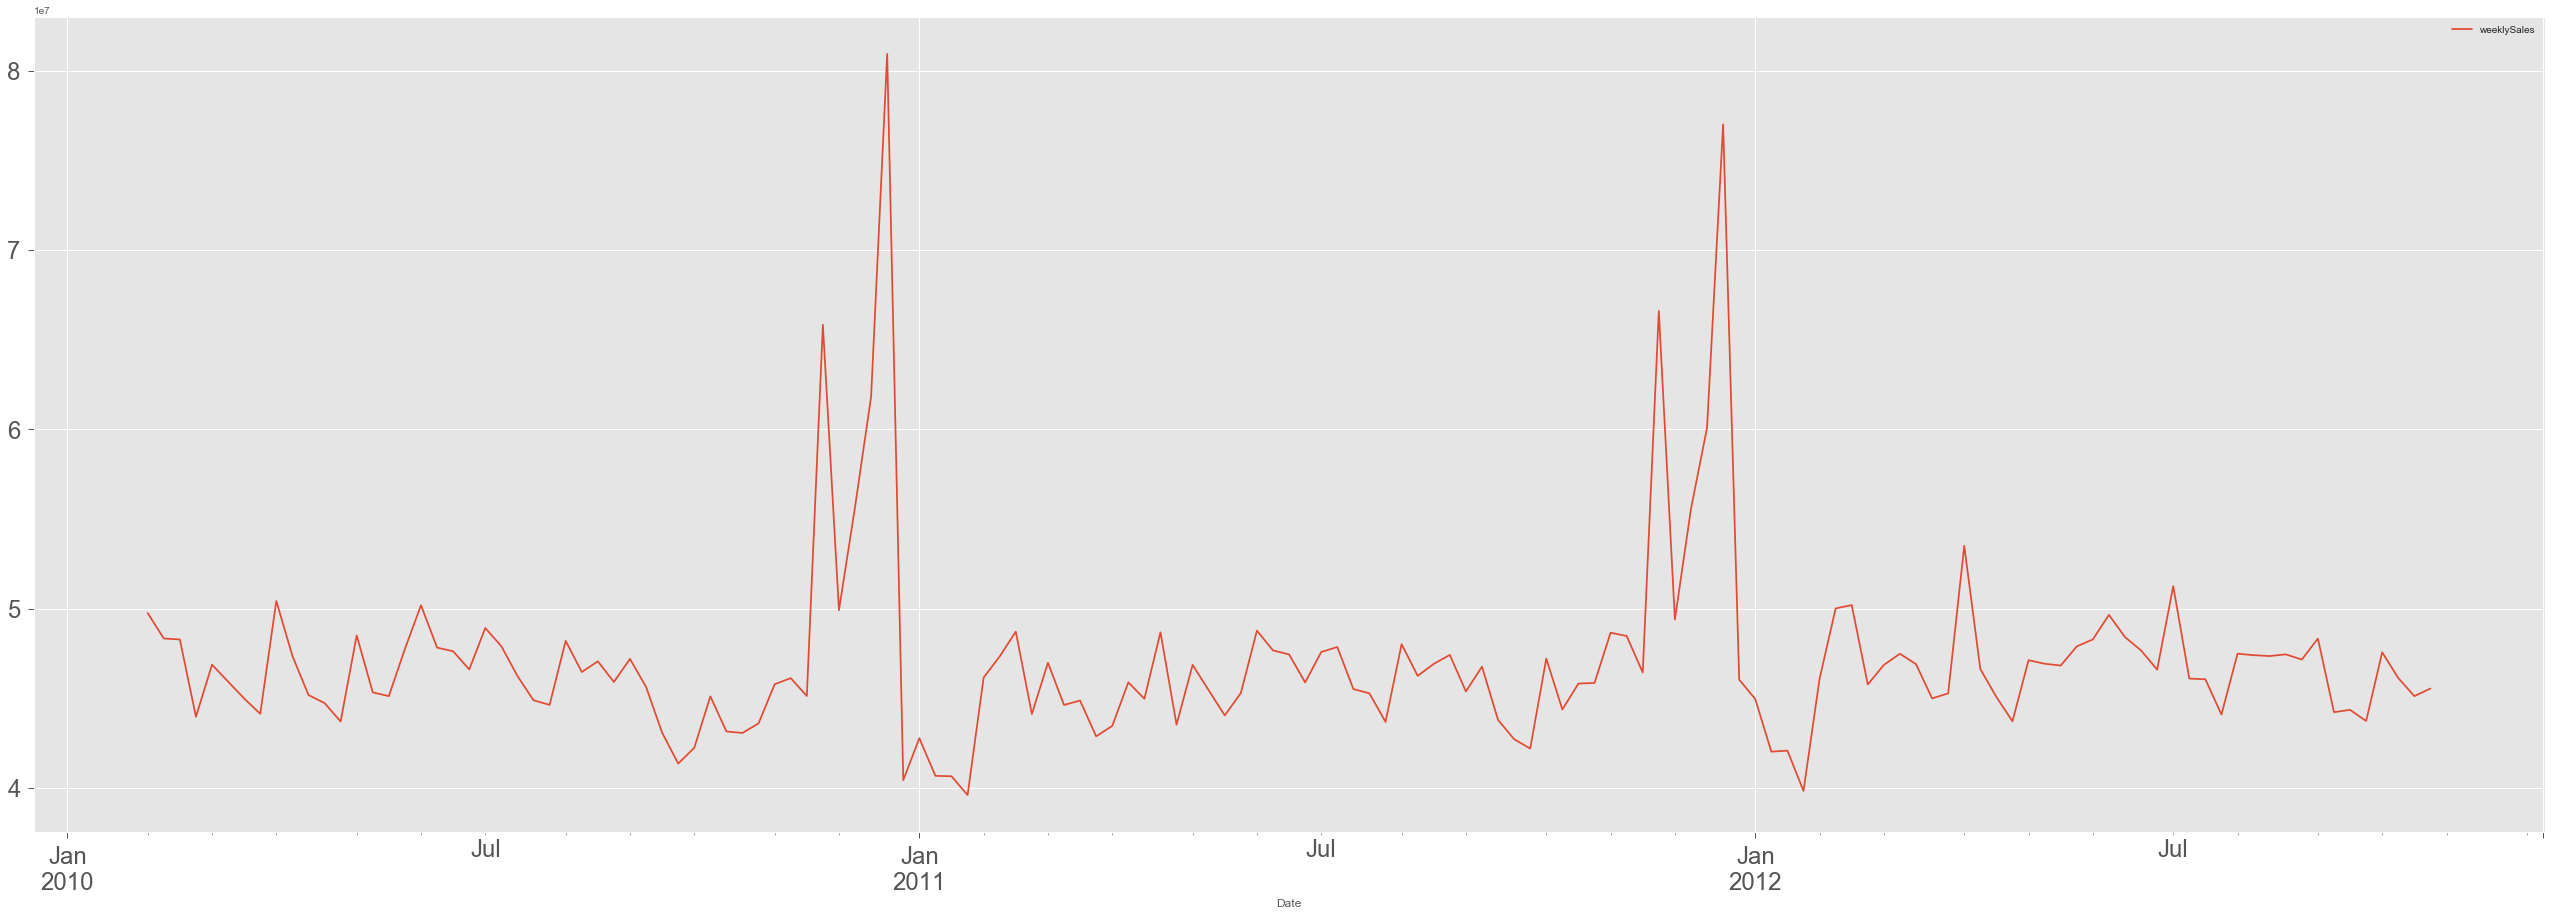

In [32]:
#aggregated sales by each day
ttl_ts.plot(figsize=(45,15), fontsize=24)

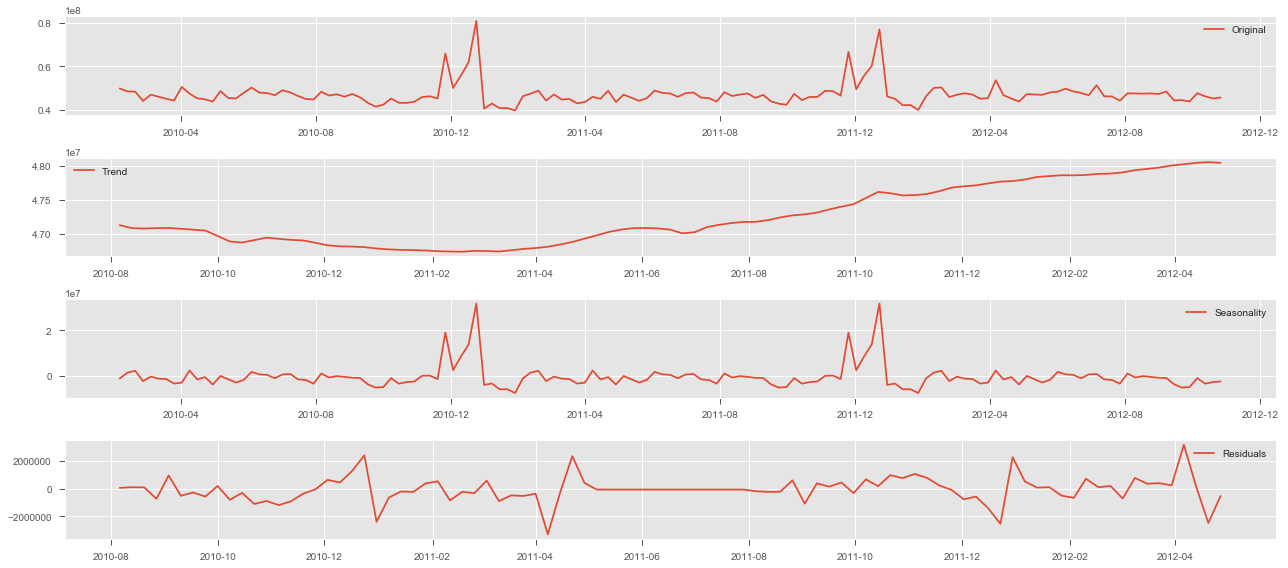

In [33]:
#The decomposition of Total sales
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(ttl_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ttl_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
dataset_forML = dataset.sort_values('Date')
test_dataset_forML = test_dataset

# The bool type is cast to int
dataset_forML['isHoliday'] = dataset_forML['isHoliday'].values + 0
test_dataset_forML['isHoliday'] = test_dataset_forML['isHoliday'].values + 0

# The categorization feature uses One-Hot
dataset_forML = pd.get_dummies(dataset_forML, columns=['Type'])
test_dataset_forML = pd.get_dummies(test_dataset_forML, columns=['Type'])

# fill missing values of CPI/Unemployment rate
test_dataset_forML[['CPI']] = test_dataset_forML[['CPI']].fillna(test_dataset_forML[['CPI']].max())
test_dataset_forML[['Unemployment']] = test_dataset_forML[['Unemployment']].fillna(test_dataset_forML[['Unemployment']].max())

# There are missing values in MarkDown
MarkDown_features=['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']
for b in range(len(MarkDown_features)):
    dataset_forML[MarkDown_features[b]] = dataset_forML[MarkDown_features[b]].fillna(0)

for b in range(len(MarkDown_features)):
    test_dataset_forML[MarkDown_features[b]] = test_dataset_forML[MarkDown_features[b]].fillna(0)

In [35]:
# split in sequential order
train_X,test_X,train_y,test_y = train_test_split(dataset_forML.drop(columns={'weeklySales'},axis=1),
                                                 dataset_forML['weeklySales'],
                                                 test_size=0.2, shuffle=False)


In [36]:
train_X = train_X.set_index('Date')
test_X = test_X.set_index('Date')
test_dataset_forML = test_dataset_forML.set_index('Date')

# Decision Tree (BM)

In [45]:
model = DecisionTreeRegressor(max_depth=30,
                               min_samples_split=30,
                               max_leaf_nodes=360)
X, y = train_X, train_y

model.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=360, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [46]:
pred_y = model.predict(test_X)
pred_y = pd.DataFrame(data = pred_y ,index=test_X.index)
fit_y = model.predict(train_X)
fit_y = pd.DataFrame(data = fit_y ,index=train_X.index)

weight = np.where(test_X['isHoliday']==0, 1, 5)

test_y2 = test_y.reset_index(drop=True) 
train_y2 = train_y.reset_index(drop=True) 

df=[]
df = pd.concat([test_X['isHoliday'].reset_index(drop=True), 
                pred_y.reset_index(drop=True),
                test_y.reset_index(drop=True)], axis=1)
df.columns = ['isHoliday', 'predict', 'actual']

df2 = pd.DataFrame({"predict": df['predict'],
                    "actual": df['actual'],
                   "Weight": weight})
df2['Derived'] = df2['Weight']*abs(df2['actual']-df2['predict'])

df_train =[]
df_train = pd.concat([fit_y.reset_index(drop=True),
                train_y.reset_index(drop=True)], axis=1)
df_train.columns = ['predict', 'actual']

In [47]:
# WMAE on validation data
WMAE = sum(df2['Derived']) / sum(df2['Weight'])
WMAE

4431.729713695629

In [48]:
train_ts = df_train.loc[:,['actual','predict']]
train_ts['Date'] = fit_y.index 

test_ts = df2.loc[:,['actual','predict']]
test_ts['Date'] = pred_y.index 

merge_ts = pd.concat([train_ts, test_ts])
merge_ts = merge_ts.groupby('Date')['actual', 'predict'].sum().reset_index()

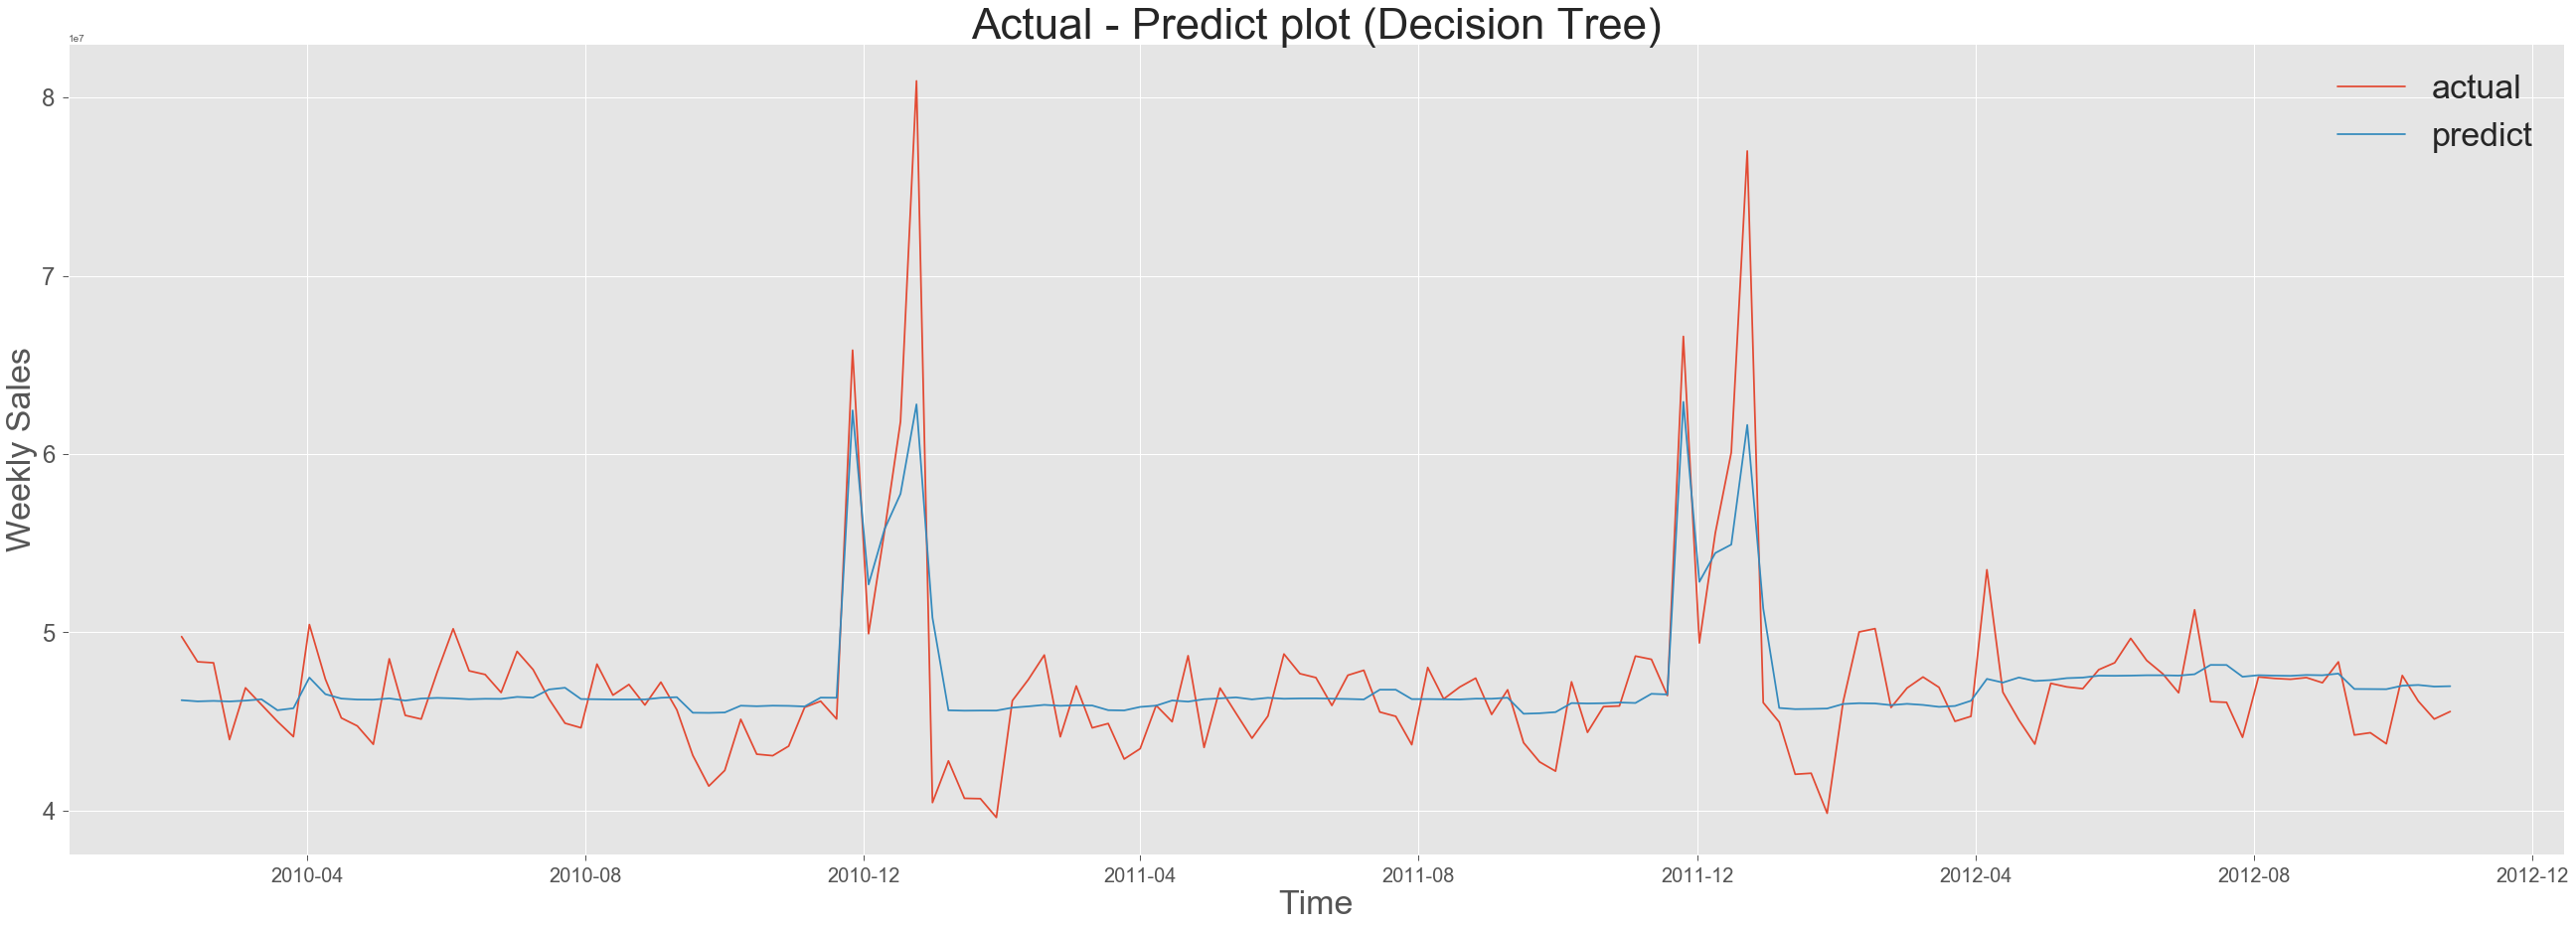

In [50]:
fig, ax = plt.subplots(figsize=(45,15))
ax.plot(merge_ts['Date'], merge_ts['actual'])
ax.plot(merge_ts['Date'], merge_ts['predict'])
ax.set_title('Actual - Predict plot (Decision Tree)', fontsize=44)
ax.legend(fontsize = 34)
ax.set_xlabel('Time',fontsize = 34)
ax.set_ylabel('Weekly Sales',fontsize = 34)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=24)
#plt.show()

### for submission to Kaggle (Decision Tree)

In [51]:
test_pred_y = model.predict(test_dataset_forML)
test_pred_y = pd.DataFrame(data = test_pred_y ,index=test_dataset_forML.index)

submitfile = pd.concat([test_dataset_forML.iloc[:, 0:2], pd.DataFrame(test_pred_y)], axis=1)
submitfile.columns = ['Store', 'Dept', 'Weekly_Sales']
submitfile['Date'] = submitfile.index
submitfile['Store'] = submitfile['Store'].astype('str')
submitfile['Date'] = submitfile['Date'].astype('str')
submitfile['Dept'] = submitfile['Dept'].astype('str')
submitfile['id'] = submitfile['Store'].str.cat(submitfile['Dept'], sep='_').str.cat(submitfile['Date'], sep='_')
#submitfile = submitfile.reset_index()
submitfile = pd.concat([submitfile.iloc[:, 4], submitfile.iloc[:, 2]], axis=1)
submitfile.head()

,id,Weekly_Sales
Date,,
2012-11-02,1_1_2012-11-02,59476.080208
2012-11-09,1_1_2012-11-09,59476.080208
2012-11-16,1_1_2012-11-16,59476.080208
2012-11-23,1_1_2012-11-23,59476.080208
2012-11-30,1_1_2012-11-30,59476.080208


In [ ]:
submitfile.to_csv('Submission.csv',index=False)

# Random Forest

In [53]:
model = RandomForestRegressor(min_samples_leaf=1,
                              min_samples_split=8,
                              n_estimators=200,
                              max_depth=110)
X, y = train_X, train_y

model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
pred_y = model.predict(test_X)
pred_y = pd.DataFrame(data = pred_y ,index=test_X.index)
fit_y = model.predict(train_X)
fit_y = pd.DataFrame(data = fit_y ,index=train_X.index)

weight = np.where(test_X['isHoliday']==0, 1, 5)

test_y2 = test_y.reset_index(drop=True) 
train_y2 = train_y.reset_index(drop=True) 

df=[]
df = pd.concat([test_X['isHoliday'].reset_index(drop=True), 
                pred_y.reset_index(drop=True),
                test_y.reset_index(drop=True)], axis=1)
df.columns = ['isHoliday', 'predict', 'actual']

df2 = pd.DataFrame({"predict": df['predict'],
                    "actual": df['actual'],
                   "Weight": weight})
df2['Derived'] = df2['Weight']*abs(df2['actual']-df2['predict'])

df_train =[]
df_train = pd.concat([fit_y.reset_index(drop=True),
                train_y.reset_index(drop=True)], axis=1)
df_train.columns = ['predict', 'actual']

In [55]:
# WMAE on validation data
WMAE = sum(df2['Derived']) / sum(df2['Weight'])
WMAE

2231.0014577120364

In [56]:
train_ts = df_train.loc[:,['actual','predict']]
train_ts['Date'] = fit_y.index 

test_ts = df2.loc[:,['actual','predict']]
test_ts['Date'] = pred_y.index 

merge_ts = pd.concat([train_ts, test_ts])
merge_ts = merge_ts.groupby('Date')['actual', 'predict'].sum().reset_index()

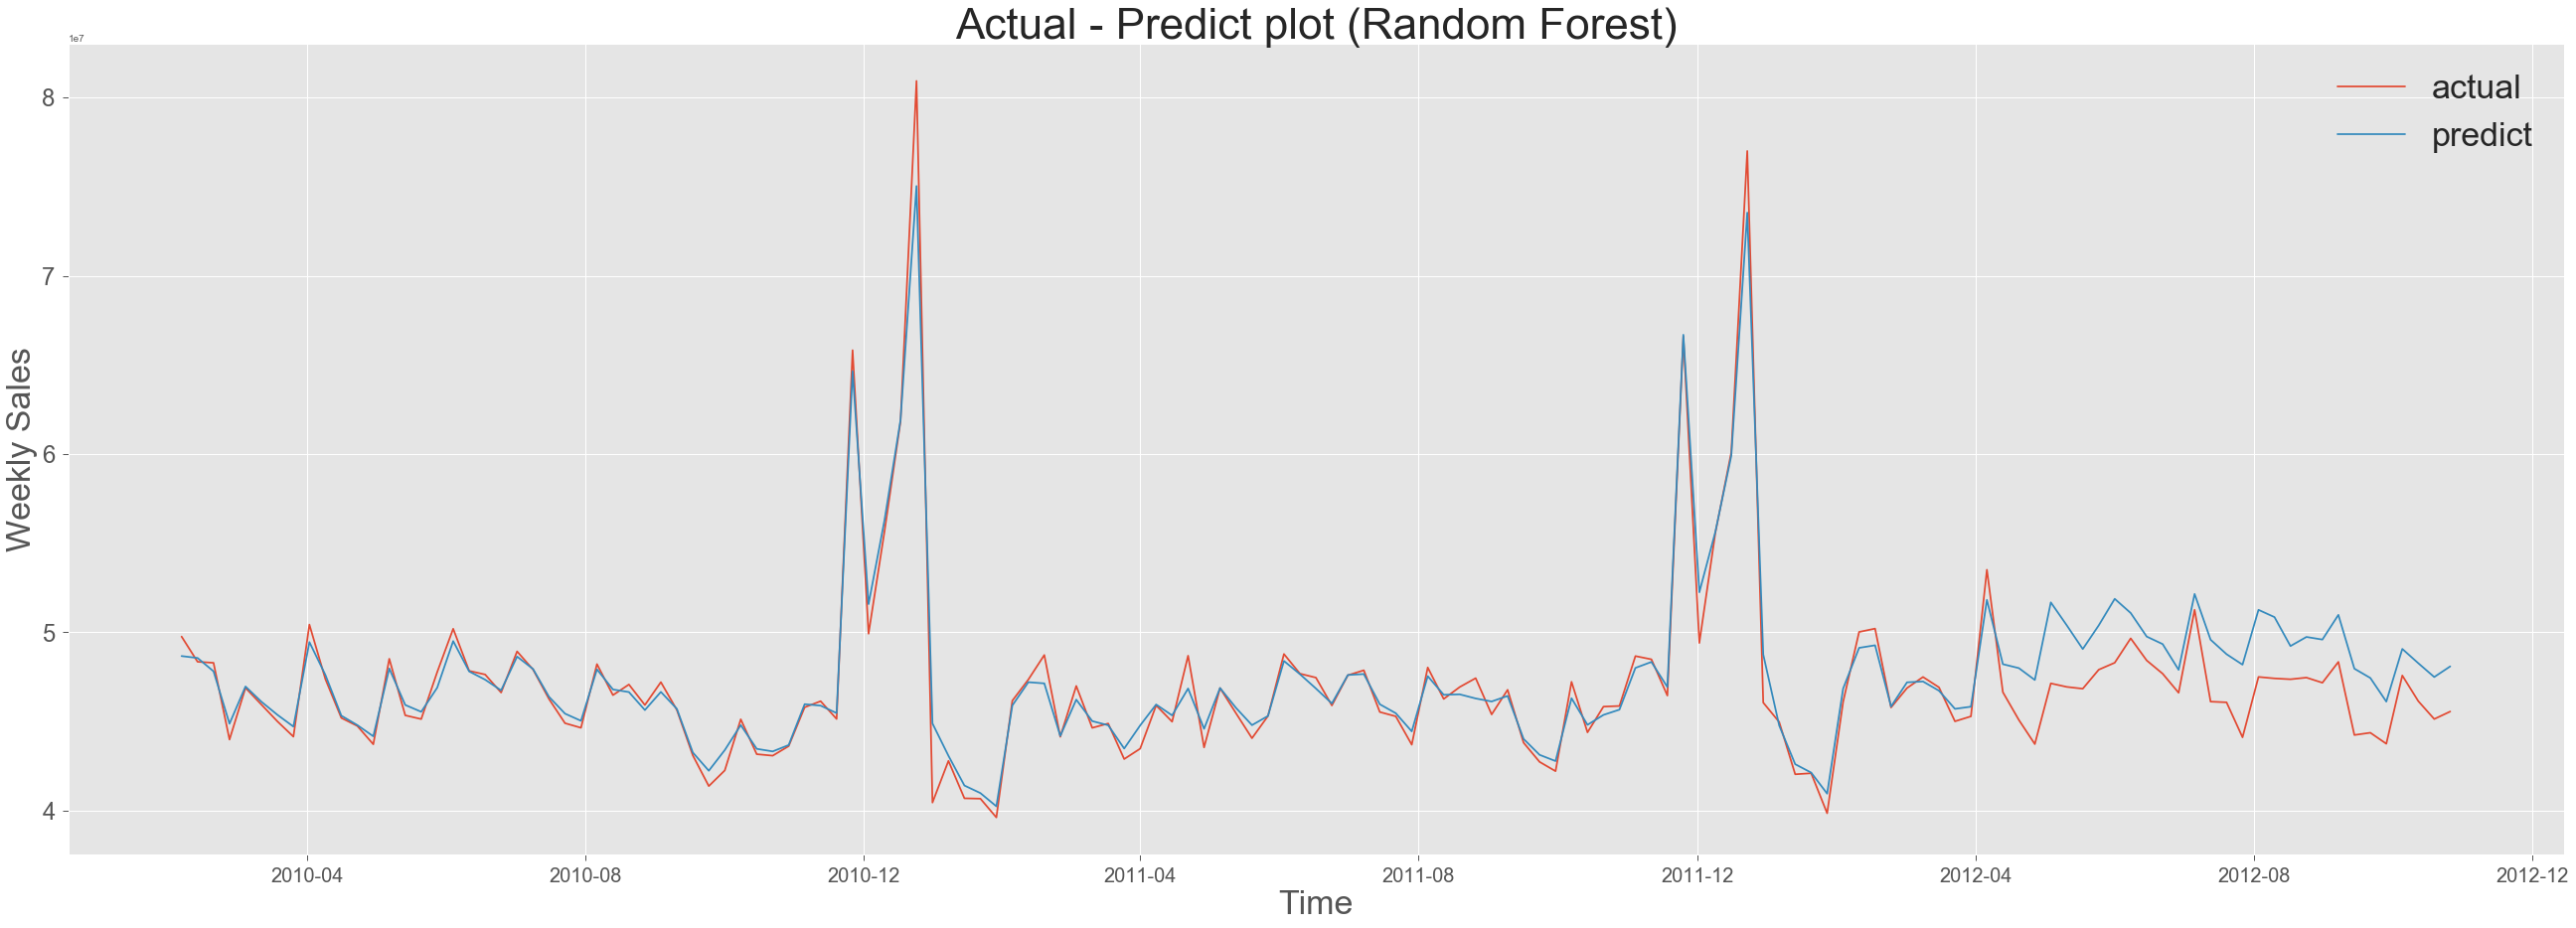

In [57]:
fig, ax = plt.subplots(figsize=(45,15))
ax.plot(merge_ts['Date'], merge_ts['actual'])
ax.plot(merge_ts['Date'], merge_ts['predict'])
ax.set_title('Actual - Predict plot (Random Forest)', fontsize=44)
ax.legend(fontsize = 34)
ax.set_xlabel('Time',fontsize = 34)
ax.set_ylabel('Weekly Sales',fontsize = 34)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=24)
#plt.show()

### for submission to Kaggle (Random Forest)

In [58]:
test_pred_y = model.predict(test_dataset_forML)
test_pred_y = pd.DataFrame(data = test_pred_y ,index=test_dataset_forML.index)

submitfile = pd.concat([test_dataset_forML.iloc[:, 0:2], pd.DataFrame(test_pred_y)], axis=1)
submitfile.columns = ['Store', 'Dept', 'Weekly_Sales']
submitfile['Date'] = submitfile.index
submitfile['Store'] = submitfile['Store'].astype('str')
submitfile['Date'] = submitfile['Date'].astype('str')
submitfile['Dept'] = submitfile['Dept'].astype('str')
submitfile['id'] = submitfile['Store'].str.cat(submitfile['Dept'], sep='_').str.cat(submitfile['Date'], sep='_')
#submitfile = submitfile.reset_index()
submitfile = pd.concat([submitfile.iloc[:, 4], submitfile.iloc[:, 2]], axis=1)
submitfile.head()

,id,Weekly_Sales
Date,,
2012-11-02,1_1_2012-11-02,92783.706012
2012-11-09,1_1_2012-11-09,74406.487752
2012-11-16,1_1_2012-11-16,82713.409038
2012-11-23,1_1_2012-11-23,85096.187629
2012-11-30,1_1_2012-11-30,94584.931304


In [ ]:
submitfile.to_csv('Submission.csv',index=False)

# XGBoost

In [60]:
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.85, colsample_bylevel = 0.8, subsample = 0.80, learning_rate = 0.1,
                      max_depth = 14, min_child_weight=0, reg_alpha = 10, reg_lambda=2, gamma=0, n_estimators = 500)
model.fit(train_X, train_y)

[20:04:17] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bynode=1, colsample_bytree=0.85, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=0, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=10, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [61]:
pred_y = model.predict(test_X)
pred_y = pd.DataFrame(data = pred_y ,index=test_X.index)
fit_y = model.predict(train_X)
fit_y = pd.DataFrame(data = fit_y ,index=train_X.index)

weight = np.where(test_X['isHoliday']==0, 1, 5)

test_y2 = test_y.reset_index(drop=True) 
train_y2 = train_y.reset_index(drop=True) 

df=[]
df = pd.concat([test_X['isHoliday'].reset_index(drop=True), 
                pred_y.reset_index(drop=True),
                test_y.reset_index(drop=True)], axis=1)
df.columns = ['isHoliday', 'predict', 'actual']

df2 = pd.DataFrame({"predict": df['predict'],
                    "actual": df['actual'],
                   "Weight": weight})
df2['Derived'] = df2['Weight']*abs(df2['actual']-df2['predict'])

df_train =[]
df_train = pd.concat([fit_y.reset_index(drop=True),
                train_y.reset_index(drop=True)], axis=1)
df_train.columns = ['predict', 'actual']

In [62]:
# WMAE on validation data
WMAE = sum(df2['Derived']) / sum(df2['Weight'])
WMAE

2133.2015567291346

In [63]:
train_ts = df_train.loc[:,['actual','predict']]
train_ts['Date'] = fit_y.index 

test_ts = df2.loc[:,['actual','predict']]
test_ts['Date'] = pred_y.index 

merge_ts = pd.concat([train_ts, test_ts])
merge_ts = merge_ts.groupby('Date')['actual', 'predict'].sum().reset_index()

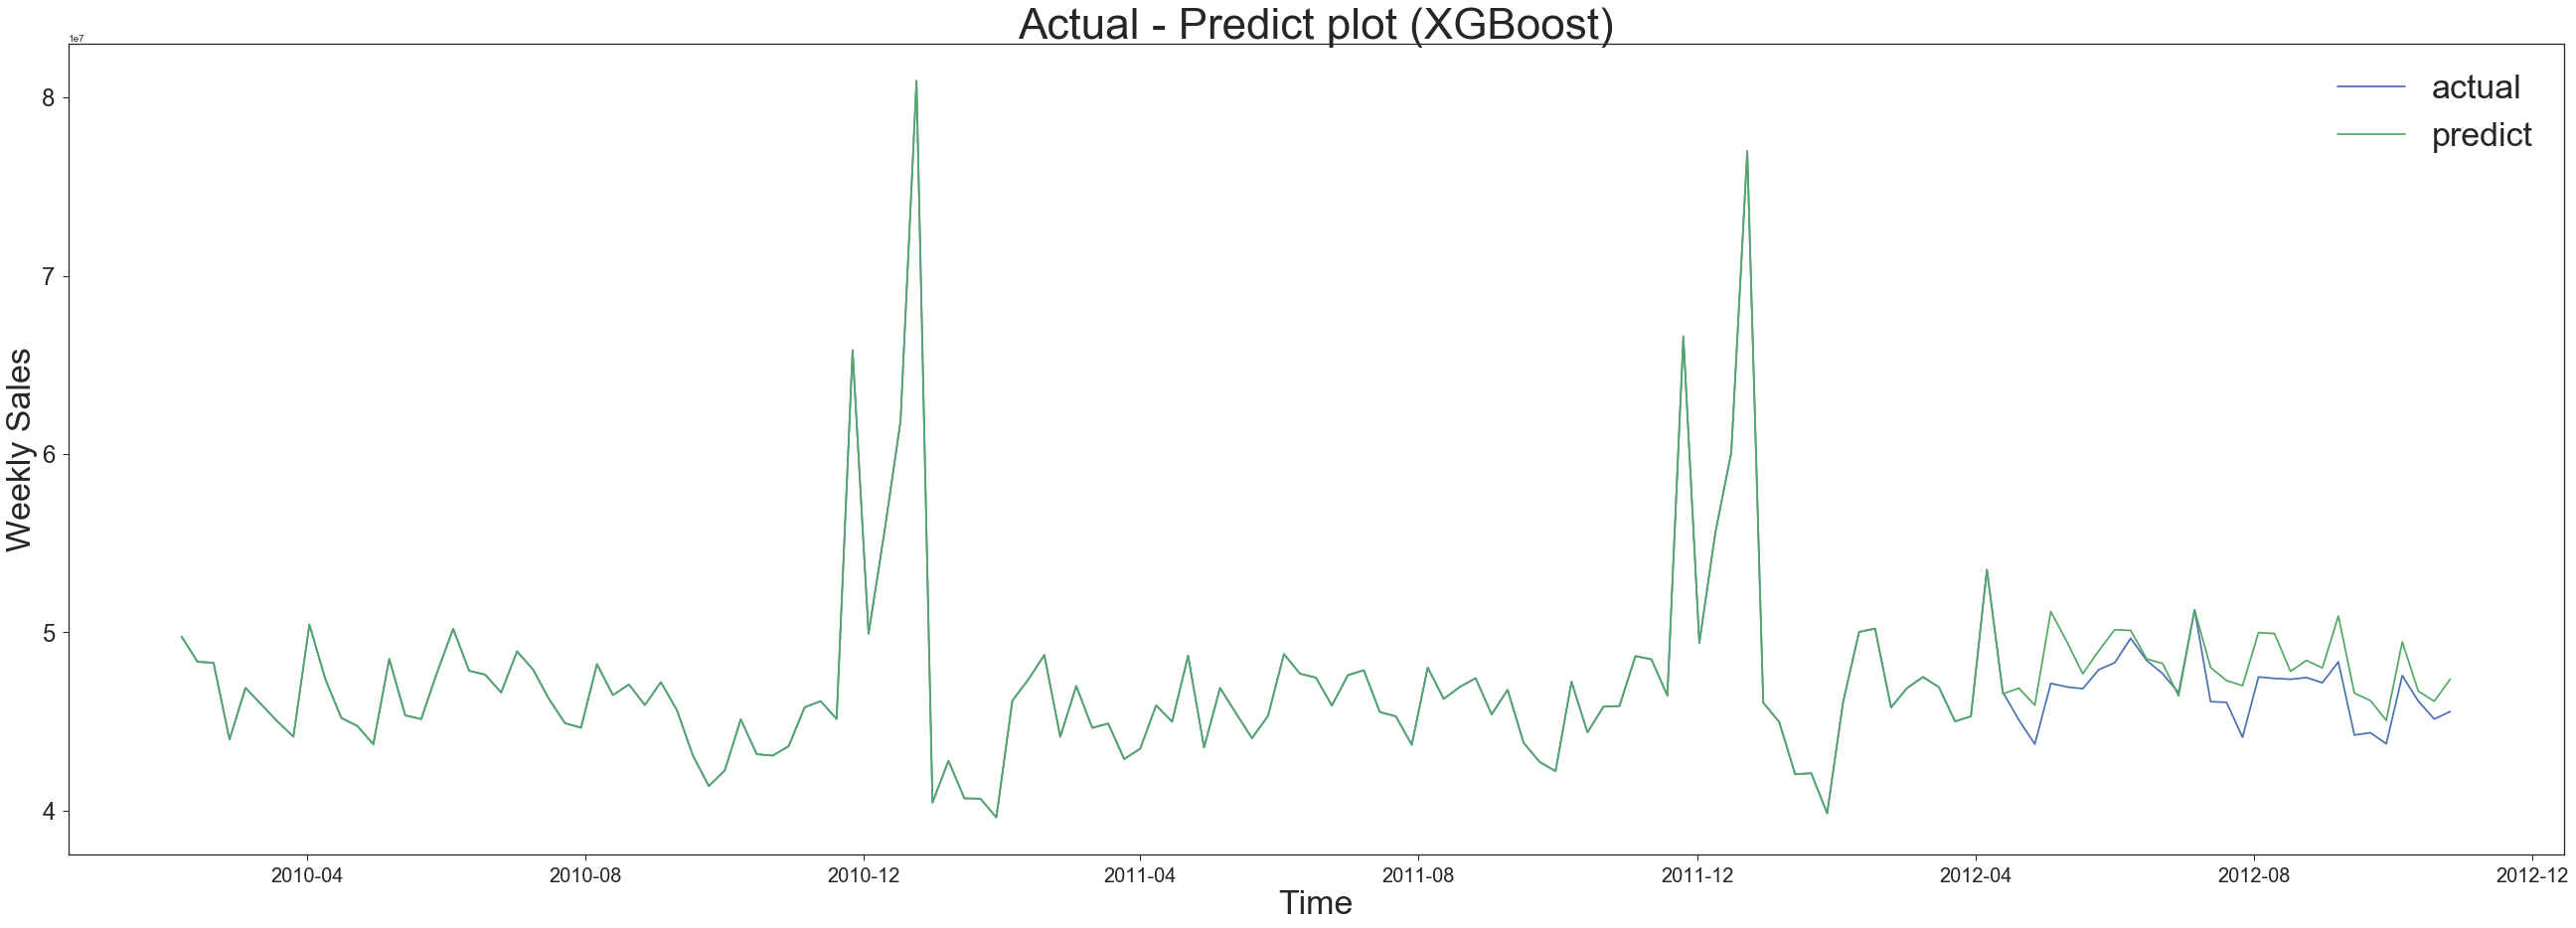

In [64]:
fig, ax = plt.subplots(figsize=(45,15))
ax.plot(merge_ts['Date'], merge_ts['actual'])
ax.plot(merge_ts['Date'], merge_ts['predict'])
ax.set_title('Actual - Predict plot (XGBoost)', fontsize=44)
ax.legend(fontsize = 34)
ax.set_xlabel('Time',fontsize = 34)
ax.set_ylabel('Weekly Sales',fontsize = 34)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=24)
#plt.show()

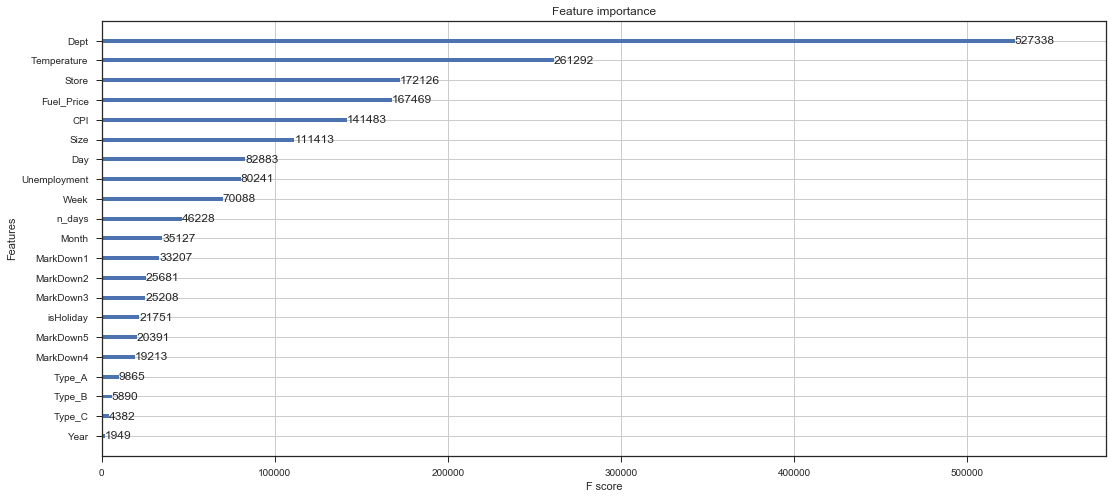

In [65]:
plot_importance(model)
plt.show()

### for submission to Kaggle  (XGBoost)

In [44]:
test_pred_y = model.predict(test_dataset_forML)
test_pred_y = pd.DataFrame(data = test_pred_y ,index=test_dataset_forML.index)

submitfile = pd.concat([test_dataset_forML.iloc[:, 0:2], pd.DataFrame(test_pred_y)], axis=1)
submitfile.columns = ['Store', 'Dept', 'Weekly_Sales']
submitfile['Date'] = submitfile.index
submitfile['Store'] = submitfile['Store'].astype('str')
submitfile['Date'] = submitfile['Date'].astype('str')
submitfile['Dept'] = submitfile['Dept'].astype('str')
submitfile['id'] = submitfile['Store'].str.cat(submitfile['Dept'], sep='_').str.cat(submitfile['Date'], sep='_')
#submitfile = submitfile.reset_index()
submitfile = pd.concat([submitfile.iloc[:, 4], submitfile.iloc[:, 2]], axis=1)
submitfile.head()

,id,Weekly_Sales
Date,,
2012-11-02,1_1_2012-11-02,56602.050781
2012-11-09,1_1_2012-11-09,46719.039062
2012-11-16,1_1_2012-11-16,48355.421875
2012-11-23,1_1_2012-11-23,34915.113281
2012-11-30,1_1_2012-11-30,37711.242188


In [ ]:
submitfile.to_csv('Submission.csv',index=False)

# LSTM 

In [277]:
# use only sales as input
dataset_forLSTM = dataset_forML.iloc[:,0:4]
dataset_forLSTM = dataset_forLSTM.sort_values(['Store', 'Dept'])
dataset_forLSTM.head()

,Store,Dept,Date,weeklySales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90


In [278]:
# concatenate "Store" and "Department" to "id"

dataset_forLSTM['Store'] = dataset_forLSTM['Store'].astype('str')
dataset_forLSTM['Dept'] = dataset_forLSTM['Dept'].astype('str')
dataset_forLSTM['id'] = dataset_forLSTM['Store'].str.cat(dataset_forLSTM['Dept'], sep='_')
dataset_forLSTM = dataset_forLSTM.iloc[:,2:5]
dataset_forLSTM.head()

,Date,weeklySales,id
0,2010-02-05,24924.50,1_1
1,2010-02-12,46039.49,1_1
2,2010-02-19,41595.55,1_1
3,2010-02-26,19403.54,1_1
4,2010-03-05,21827.90,1_1


In [279]:
dataset_forLSTM_pivot = dataset_forLSTM.pivot_table(values=['weeklySales'], index=['Date'], columns=['id'], aggfunc='sum')
dataset_forLSTM_pivot = dataset_forLSTM_pivot.fillna(0)

In [280]:
dataset_forLSTM_pivot_array = dataset_forLSTM_pivot.iloc[:,:].values
dataset_forLSTM_pivot_array

array([[40212.84, 48027.87, 36705.57, ...,  2438.08,   668.48,     0.  ],
       [67699.32, 50595.72, 31052.34, ...,  2304.09,   766.93,     0.  ],
       [49748.33, 51199.72, 33224.65, ...,  1944.11,   607.02,     0.  ],
       ...,
       [40626.47, 48684.03, 25425.08, ...,  3675.99,     0.  ,     0.  ],
       [44224.36, 46947.21, 25507.61, ...,  3540.05,     0.  ,     0.  ],
       [58409.83, 43637.06, 25448.11, ...,  4752.25,     0.  ,     0.  ]])

In [281]:
dataset_forLSTM_pivot_array.shape

(143, 3331)

In [282]:
# Scaling
sc = MinMaxScaler(feature_range=(0,1))
dataset_forLSTM_set_scaled = sc.fit_transform(dataset_forLSTM_pivot_array[:,:])

print(dataset_forLSTM_set_scaled.shape)

(143, 3331)


In [283]:
f = dataset_forLSTM_set_scaled[:,0]
length_of_sequences = len(dataset_forLSTM_pivot)
n_features = len(dataset_forLSTM_pivot.columns)
maxlen = 4

input_data_LSTM = []
input_data_LSTM2 = []
input_data_LSTM3 = []
target = []
target2 = []
target3 = []

for i in range(0, length_of_sequences - maxlen):
    input_data_LSTM.append(f[i: i + maxlen])
    input_data_LSTM3 = np.array(input_data_LSTM)
    target.append(f[i + maxlen])
    target3 = np.array(target)

for j in range(1, n_features):
    f = dataset_forLSTM_set_scaled[:,j]#dataset_forLSTM_pivot.iloc[:,j].values
    input_data_LSTM = []
    target = []
    for i in range(0, length_of_sequences - maxlen):
        input_data_LSTM.append(f[i: i + maxlen])
        target.append(f[i + maxlen])
    input_data_LSTM2 = np.array(input_data_LSTM)
    target2 = np.array(target)
    input_data_LSTM3 = np.dstack([input_data_LSTM3, input_data_LSTM2])
    target3 = np.vstack([target3, target2])

target3 = target3.T
#target3 = target3.reshape((target3.shape[1], target3.shape[0]))

In [284]:
input_data_LSTM3.shape

(139, 4, 3331)

In [285]:
target3.shape #(143-maxlen, 3331)

(139, 3331)

In [286]:
train_test_row = round(len(target3)*0.8)  # val set 20%
X_train, X_test = np.split(input_data_LSTM3, [train_test_row], axis=0)
y_train, y_test = np.split(target3, [train_test_row], axis=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(111, 4, 3331) (111, 3331) (28, 4, 3331) (28, 3331)


In [287]:
# Initialising RNN
regressor = Sequential()

In [288]:
# Adding the first LSTM layer and some Dropout regularization
# Dropout regularization is added to avoid overfitting

regressor.add(LSTM(units = 200, return_sequences = True, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.1))

In [289]:
# adding a second LSTM layer and some dropout regularization
regressor.add(LSTM(units = 200, return_sequences = True, activation = 'relu'))
regressor.add(Dropout(0.1))

In [290]:
# adding a third LSTM layer and some dropout regularization
regressor.add(LSTM(units = 200, return_sequences = False, activation = 'relu'))
regressor.add(Dropout(0.1))
# Adding the output layer
regressor.add(Dense(units=3331, activation = 'linear'))
# Compiling the RNN
regressor.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['accuracy'])

In [291]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 4, 200)            2825600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 200)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 4, 200)            320800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 200)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3331)              669531    
Total para

In [292]:
# Fitting the RNN to the training set
history = regressor.fit(X_train, 
              y_train, 
              epochs = 10000, 
              batch_size = 512,
              verbose = 1,
                       shuffle = False)

Epoch 1/10000
111/111 [==============================] - 7s 62ms/step - loss: 0.1233 - acc: 0.0000e+00
Epoch 2/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.1225 - acc: 0.0000e+00
Epoch 3/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.1208 - acc: 0.0000e+00
Epoch 4/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.1154 - acc: 0.0000e+00
Epoch 5/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.1004 - acc: 0.0000e+00
Epoch 6/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.1111 - acc: 0.0090
Epoch 7/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0806 - acc: 0.0000e+00
Epoch 8/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0773 - acc: 0.0000e+00
Epoch 9/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0641 - acc: 0.0000e+00
Epoch 10/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0703 

Epoch 81/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0206 - acc: 0.0000e+00
Epoch 82/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0204 - acc: 0.0000e+00
Epoch 83/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0201 - acc: 0.0000e+00
Epoch 84/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0203 - acc: 0.0000e+00
Epoch 85/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0205 - acc: 0.0000e+00
Epoch 86/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0202 - acc: 0.0000e+00
Epoch 87/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0201 - acc: 0.0000e+00
Epoch 88/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0198 - acc: 0.0000e+00
Epoch 89/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0197 - acc: 0.0000e+00
Epoch 90/10000
111/111 [==============================] - 0s 2ms/step - l

111/111 [==============================] - 0s 2ms/step - loss: 0.0131 - acc: 0.0000e+00
Epoch 161/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0132 - acc: 0.0000e+00
Epoch 162/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0131 - acc: 0.0000e+00
Epoch 163/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0130 - acc: 0.0000e+00
Epoch 164/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0127 - acc: 0.0000e+00
Epoch 165/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0131 - acc: 0.0000e+00
Epoch 166/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0133 - acc: 0.0000e+00
Epoch 167/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0128 - acc: 0.0000e+00
Epoch 168/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0132 - acc: 0.0000e+00
Epoch 169/10000
111/111 [==============================] - 0s 2ms/step - loss: 0

Epoch 240/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.0000e+00
Epoch 241/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0102 - acc: 0.0090
Epoch 242/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.0090
Epoch 243/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0098 - acc: 0.0000e+00
Epoch 244/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0102 - acc: 0.0000e+00
Epoch 245/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.0090
Epoch 246/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.0090
Epoch 247/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0098 - acc: 0.0270
Epoch 248/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.0090
Epoch 249/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0103 - 

Epoch 322/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0082 - acc: 0.0270
Epoch 323/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0084 - acc: 0.0180
Epoch 324/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0084 - acc: 0.0360
Epoch 325/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0083 - acc: 0.0180
Epoch 326/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0083 - acc: 0.0450
Epoch 327/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0083 - acc: 0.0270
Epoch 328/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0087 - acc: 0.0180
Epoch 329/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0086 - acc: 0.0360
Epoch 330/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0080 - acc: 0.0180
Epoch 331/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0081 - acc: 0.0000e

Epoch 404/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0073 - acc: 0.0180
Epoch 405/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0075 - acc: 0.0360
Epoch 406/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0072 - acc: 0.0180
Epoch 407/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0070 - acc: 0.0270
Epoch 408/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0071 - acc: 0.0270
Epoch 409/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0069 - acc: 0.0180
Epoch 410/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0072 - acc: 0.0450
Epoch 411/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0070 - acc: 0.0090
Epoch 412/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0071 - acc: 0.0270
Epoch 413/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0073 - acc: 0.0180


Epoch 486/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0069 - acc: 0.0270
Epoch 487/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0068 - acc: 0.0270
Epoch 488/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0060 - acc: 0.0090
Epoch 489/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0066 - acc: 0.0270
Epoch 490/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0063 - acc: 0.0270
Epoch 491/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0066 - acc: 0.0180
Epoch 492/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0061 - acc: 0.0180
Epoch 493/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0064 - acc: 0.0180
Epoch 494/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0065 - acc: 0.0090
Epoch 495/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0060 - acc: 0.0270


Epoch 568/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0055 - acc: 0.0180
Epoch 569/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0059 - acc: 0.0360
Epoch 570/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0054 - acc: 0.0180
Epoch 571/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0053 - acc: 0.0090
Epoch 572/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0054 - acc: 0.0180
Epoch 573/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0057 - acc: 0.0090
Epoch 574/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0054 - acc: 0.0090
Epoch 575/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0054 - acc: 0.0090
Epoch 576/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0057 - acc: 0.0180
Epoch 577/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0055 - acc: 0.0180


Epoch 650/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 0.0180
Epoch 651/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0055 - acc: 0.0090
Epoch 652/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 0.0360
Epoch 653/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 0.0270
Epoch 654/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0049 - acc: 0.0180
Epoch 655/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0050 - acc: 0.0180
Epoch 656/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0049 - acc: 0.0270
Epoch 657/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0052 - acc: 0.0270
Epoch 658/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0052 - acc: 0.0270
Epoch 659/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0045 - acc: 0.0180


Epoch 732/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0044 - acc: 0.0090
Epoch 733/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0046 - acc: 0.0450
Epoch 734/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0047 - acc: 0.0180
Epoch 735/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0042 - acc: 0.0180
Epoch 736/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0045 - acc: 0.0360
Epoch 737/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0044 - acc: 0.0180
Epoch 738/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0047 - acc: 0.0090
Epoch 739/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0041 - acc: 0.0270
Epoch 740/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0047 - acc: 0.0270
Epoch 741/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0042 - acc: 0.0090


Epoch 814/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0042 - acc: 0.0180
Epoch 815/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0040 - acc: 0.0180
Epoch 816/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0040 - acc: 0.0180
Epoch 817/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0044 - acc: 0.0360
Epoch 818/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0037 - acc: 0.0270
Epoch 819/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0045 - acc: 0.0450
Epoch 820/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0042 - acc: 0.0270
Epoch 821/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0043 - acc: 0.0450
Epoch 822/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0039 - acc: 0.0450
Epoch 823/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0043 - acc: 0.0360


Epoch 896/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0035 - acc: 0.0541
Epoch 897/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0039 - acc: 0.0450
Epoch 898/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0036 - acc: 0.0450
Epoch 899/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0039 - acc: 0.0450
Epoch 900/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0037 - acc: 0.0360
Epoch 901/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0037 - acc: 0.0450
Epoch 902/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0035 - acc: 0.0631
Epoch 903/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0037 - acc: 0.0270
Epoch 904/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0037 - acc: 0.0631
Epoch 905/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0041 - acc: 0.0450


Epoch 978/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0033 - acc: 0.0450
Epoch 979/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0035 - acc: 0.0450
Epoch 980/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0033 - acc: 0.0450
Epoch 981/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0033 - acc: 0.0450
Epoch 982/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 0.0901
Epoch 983/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0036 - acc: 0.0901
Epoch 984/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 0.0360
Epoch 985/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 0.0721
Epoch 986/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0631
Epoch 987/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0450


Epoch 1060/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0450
Epoch 1061/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0360
Epoch 1062/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0450
Epoch 1063/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0270
Epoch 1064/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0034 - acc: 0.0721
Epoch 1065/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0034 - acc: 0.0541
Epoch 1066/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0450
Epoch 1067/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 0.0450
Epoch 1068/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0450
Epoch 1069/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0032 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0631
Epoch 1142/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0631
Epoch 1143/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 0.0901
Epoch 1144/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0450
Epoch 1145/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0541
Epoch 1146/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0450
Epoch 1147/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0033 - acc: 0.0360
Epoch 1148/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.1081
Epoch 1149/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0035 - acc: 0.0360
Epoch 1150/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0631
Epoch 1

Epoch 1223/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 0.0811
Epoch 1224/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0721
Epoch 1225/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0991
Epoch 1226/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 0.0631
Epoch 1227/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 0.0541
Epoch 1228/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0721
Epoch 1229/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0027 - acc: 0.0721
Epoch 1230/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0631
Epoch 1231/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0360
Epoch 1232/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0026 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.1081
Epoch 1305/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0631
Epoch 1306/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.0991
Epoch 1307/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0631
Epoch 1308/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 0.0721
Epoch 1309/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.1171
Epoch 1310/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.0811
Epoch 1311/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0541
Epoch 1312/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0811
Epoch 1313/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0631
Epoch 1

Epoch 1386/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.1081
Epoch 1387/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0360
Epoch 1388/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.0180
Epoch 1389/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0721
Epoch 1390/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.1081
Epoch 1391/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0026 - acc: 0.1081
Epoch 1392/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0991
Epoch 1393/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0721
Epoch 1394/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0991
Epoch 1395/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0027 - acc: 0.0991
Epoch 1468/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0541
Epoch 1469/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.0450
Epoch 1470/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0026 - acc: 0.0631
Epoch 1471/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0901
Epoch 1472/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0991
Epoch 1473/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0991
Epoch 1474/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0901
Epoch 1475/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.0631
Epoch 1476/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.0450
Epoch 1

Epoch 1549/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0721
Epoch 1550/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0721
Epoch 1551/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.1081
Epoch 1552/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0901
Epoch 1553/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0721
Epoch 1554/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0901
Epoch 1555/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1532
Epoch 1556/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0901
Epoch 1557/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0811
Epoch 1558/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0901
Epoch 1631/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 1632/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0811
Epoch 1633/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0541
Epoch 1634/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 1635/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 0.1171
Epoch 1636/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0631
Epoch 1637/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0991
Epoch 1638/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 1639/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 1

Epoch 1712/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.1171
Epoch 1713/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0811
Epoch 1714/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 1715/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0721
Epoch 1716/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.1171
Epoch 1717/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 1718/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0811
Epoch 1719/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0631
Epoch 1720/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 1721/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.1712
Epoch 1794/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0991
Epoch 1795/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1351
Epoch 1796/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0811
Epoch 1797/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0631
Epoch 1798/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0811
Epoch 1799/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 1800/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 1801/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 1802/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0991
Epoch 1

Epoch 1875/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0991
Epoch 1876/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 1877/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0631
Epoch 1878/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 1879/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0450
Epoch 1880/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0811
Epoch 1881/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1441
Epoch 1882/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1171
Epoch 1883/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1171
Epoch 1884/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0991
Epoch 1957/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 1958/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1261
Epoch 1959/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1532
Epoch 1960/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 1961/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1351
Epoch 1962/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1351
Epoch 1963/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 1964/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0721
Epoch 1965/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1532
Epoch 1

Epoch 2038/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 2039/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0901
Epoch 2040/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0721
Epoch 2041/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1261
Epoch 2042/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0991
Epoch 2043/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 2044/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 0.0721
Epoch 2045/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 2046/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.0901
Epoch 2047/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 2120/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0901
Epoch 2121/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.1171
Epoch 2122/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 2123/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 2124/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0901
Epoch 2125/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 2126/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0022 - acc: 0.0991
Epoch 2127/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 2128/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0901
Epoch 2

Epoch 2201/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 2202/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 2203/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 2204/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1532
Epoch 2205/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1081
Epoch 2206/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1261
Epoch 2207/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.1171
Epoch 2208/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1171
Epoch 2209/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0991
Epoch 2210/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0721
Epoch 2283/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 2284/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0991
Epoch 2285/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0901
Epoch 2286/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 2287/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 2288/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1622
Epoch 2289/10000
111/111 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 0.1081
Epoch 2290/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0811
Epoch 2291/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.1171
Epoch 2

Epoch 2364/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1261
Epoch 2365/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 2366/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 2367/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 2368/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 2369/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0811
Epoch 2370/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 2371/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 2372/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1261
Epoch 2373/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 2446/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 2447/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0811
Epoch 2448/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1171
Epoch 2449/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1261
Epoch 2450/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 2451/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1622
Epoch 2452/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0721
Epoch 2453/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.1441
Epoch 2454/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 2

Epoch 2527/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 2528/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1081
Epoch 2529/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 2530/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.1171
Epoch 2531/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 2532/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 2533/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.1171
Epoch 2534/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 2535/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1261
Epoch 2536/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0811
Epoch 2609/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 2610/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 2611/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 2612/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1622
Epoch 2613/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 0.1532
Epoch 2614/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 2615/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.0901
Epoch 2616/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 2617/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 2

Epoch 2690/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0721
Epoch 2691/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1441
Epoch 2692/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 2693/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1351
Epoch 2694/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 2695/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 2696/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 2697/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 2698/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0721
Epoch 2699/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1532
Epoch 2772/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1261
Epoch 2773/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 2774/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 2775/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1441
Epoch 2776/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 2777/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 2778/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 2779/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 2780/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 2

Epoch 2853/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 2854/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 2855/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 2856/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 2857/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1441
Epoch 2858/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 2859/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 2860/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1532
Epoch 2861/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 2862/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 2935/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 2936/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 2937/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 2938/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 2939/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1712
Epoch 2940/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 2941/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 2942/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 2943/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 2

Epoch 3016/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 3017/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 3018/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 3019/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 3020/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1171
Epoch 3021/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 3022/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 3023/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 3024/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 3025/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 3098/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 3099/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 3100/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 3101/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 3102/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 3103/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 3104/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 3105/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 3106/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 3

Epoch 3179/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7097e-04 - acc: 0.0991
Epoch 3180/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1622
Epoch 3181/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 3182/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 3183/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 3184/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 3185/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1622
Epoch 3186/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 3187/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 3188/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 3261/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 3262/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 3263/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 3264/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9436e-04 - acc: 0.1351
Epoch 3265/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1622
Epoch 3266/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 3267/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0901
Epoch 3268/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0811
Epoch 3269/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epo

Epoch 3342/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0811
Epoch 3343/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0811
Epoch 3344/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 3345/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1622
Epoch 3346/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 3347/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 3348/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 3349/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1712
Epoch 3350/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1532
Epoch 3351/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3424/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 3425/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1802
Epoch 3426/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 3427/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1351
Epoch 3428/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3429/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 3430/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 3431/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3432/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 3

Epoch 3505/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 3506/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 3507/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 3508/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 3509/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 3510/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1892
Epoch 3511/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 3512/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 3513/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0721
Epoch 3514/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1892
Epoch 3587/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 3588/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 3589/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1802
Epoch 3590/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 3591/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 3592/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1712
Epoch 3593/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6566e-04 - acc: 0.1802
Epoch 3594/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 3595/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0901
Epo

Epoch 3668/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5818e-04 - acc: 0.1441
Epoch 3669/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3670/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 3671/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 3672/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 3673/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 3674/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 3675/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 3676/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.4326e-04 - acc: 0.1351
Epoch 3677/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 3749/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 3750/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 3751/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 3752/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0631
Epoch 3753/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 3754/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1351
Epoch 3755/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 3756/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 3757/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0901
Epoch 3758/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1441
Epoch 3831/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 3832/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 3833/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 3834/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 3835/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 3836/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 3837/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 3838/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 3839/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1712
Epoch 3

Epoch 3912/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 3913/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 3914/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 3915/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1622
Epoch 3916/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7329e-04 - acc: 0.0811
Epoch 3917/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1712
Epoch 3918/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 3919/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 3920/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3921/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 

111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 3994/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 3995/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 3996/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 3997/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 3998/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 3999/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0811
Epoch 4000/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0811
Epoch 4001/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 4002/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 4

Epoch 4075/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 4076/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0721
Epoch 4077/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 4078/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 4079/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 4080/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4081/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1081
Epoch 4082/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 4083/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 4084/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - ac

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 4157/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1622
Epoch 4158/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7080e-04 - acc: 0.1171
Epoch 4159/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.0991
Epoch 4160/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0721
Epoch 4161/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.2425e-04 - acc: 0.1532
Epoch 4162/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 4163/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1802
Epoch 4164/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1712
Epoch 4165/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1351

111/111 [==============================] - 0s 2ms/step - loss: 9.6131e-04 - acc: 0.0991
Epoch 4238/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 4239/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8645e-04 - acc: 0.1171
Epoch 4240/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 4241/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5017e-04 - acc: 0.0991
Epoch 4242/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 4243/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 4244/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 4245/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 4246/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.

111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 4319/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 4320/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 4321/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 4322/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 4323/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 4324/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 4325/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 4326/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 4327/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 4

111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1802
Epoch 4400/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 4401/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 4402/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4403/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 4404/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 4405/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 4406/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 4407/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 4408/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 4

111/111 [==============================] - 0s 2ms/step - loss: 9.3525e-04 - acc: 0.1261
Epoch 4481/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 4482/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 4483/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 4484/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.2155e-04 - acc: 0.1622
Epoch 4485/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 4486/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0721
Epoch 4487/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 4488/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 4489/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991

111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0631
Epoch 4562/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 4563/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 4564/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 4565/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 4566/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 4567/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 4568/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 4569/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 4570/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1892
Epoch 4

Epoch 4642/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 4643/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0721
Epoch 4644/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 4645/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 4646/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4647/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1622
Epoch 4648/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 4649/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1712
Epoch 4650/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0811
Epoch 4651/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - ac

Epoch 4723/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 4724/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4725/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 4726/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7865e-04 - acc: 0.0991
Epoch 4727/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 4728/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 4729/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9752e-04 - acc: 0.1351
Epoch 4730/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 4731/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 4732/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 4804/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0811
Epoch 4805/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 4806/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 4807/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 4808/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 4809/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1712
Epoch 4810/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 4811/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 4812/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 4813/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - ac

Epoch 4885/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 4886/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0233e-04 - acc: 0.1532
Epoch 4887/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1892
Epoch 4888/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1622
Epoch 4889/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4890/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 4891/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1712
Epoch 4892/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 4893/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1081
Epoch 4894/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 

Epoch 4966/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4967/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4968/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 4969/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 4970/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1712
Epoch 4971/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1712
Epoch 4972/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 4973/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 4974/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 4975/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - ac

Epoch 5047/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 5048/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 5049/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 5050/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 5051/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5052/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 5053/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1802
Epoch 5054/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 5055/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.2678e-04 - acc: 0.1712
Epoch 5056/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 

Epoch 5128/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5129/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - acc: 0.0811
Epoch 5130/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6349e-04 - acc: 0.1532
Epoch 5131/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8332e-04 - acc: 0.1712
Epoch 5132/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 5133/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 5134/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.0811
Epoch 5135/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.3214e-04 - acc: 0.1081
Epoch 5136/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 5137/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 5209/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 5210/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 5211/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0811
Epoch 5212/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1622
Epoch 5213/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1171
Epoch 5214/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0541
Epoch 5215/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0901
Epoch 5216/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1622
Epoch 5217/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 5218/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - ac

Epoch 5290/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 5291/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 5292/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 5293/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 5294/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9375e-04 - acc: 0.1261
Epoch 5295/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 5296/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 5297/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 5298/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4394e-04 - acc: 0.1081
Epoch 5299/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3

Epoch 5371/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0901
Epoch 5372/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9338e-04 - acc: 0.1171
Epoch 5373/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5374/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1712
Epoch 5375/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5376/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 5377/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5358e-04 - acc: 0.1622
Epoch 5378/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 5379/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5380/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5

Epoch 5452/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 5453/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 5454/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 5455/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 5456/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3307e-04 - acc: 0.1622
Epoch 5457/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1532
Epoch 5458/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 5459/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 5460/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1870e-04 - acc: 0.1982
Epoch 5461/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 5533/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 5534/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8234e-04 - acc: 0.1171
Epoch 5535/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1982
Epoch 5536/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1622
Epoch 5537/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 5538/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 5539/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5540/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 5541/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 5542/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9271e

Epoch 5614/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 5615/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 5616/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 5617/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 5618/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 5619/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 5620/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 5621/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 5622/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 5623/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - ac

Epoch 5695/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0901
Epoch 5696/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 5697/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5698/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1802
Epoch 5699/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 5700/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0901
Epoch 5701/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9234e-04 - acc: 0.1171
Epoch 5702/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 5703/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0991
Epoch 5704/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.2313e

Epoch 5776/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 5777/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 5778/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 5779/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 5780/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5781/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0811
Epoch 5782/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 5783/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 5784/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5785/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5777e-04 

Epoch 5857/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5858/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 5859/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0811
Epoch 5860/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 5861/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 5862/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1802
Epoch 5863/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 5864/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.6752e-04 - acc: 0.1261
Epoch 5865/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 5866/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8275e

Epoch 5938/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 5939/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7710e-04 - acc: 0.0991
Epoch 5940/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 5941/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 5942/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4130e-04 - acc: 0.1351
Epoch 5943/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 5944/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 5945/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 5946/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5489e-04 - acc: 0.0901
Epoch 5947/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 6019/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6394e-04 - acc: 0.1532
Epoch 6020/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 6021/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1622
Epoch 6022/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 6023/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5268e-04 - acc: 0.1081
Epoch 6024/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3447e-04 - acc: 0.1532
Epoch 6025/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 6026/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 6027/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.0721
Epoch 6028/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 6100/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 6101/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.2072
Epoch 6102/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 6103/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0901
Epoch 6104/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 6105/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 6106/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 6107/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 6108/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 6109/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - ac

Epoch 6181/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 6182/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9054e-04 - acc: 0.1351
Epoch 6183/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 6184/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 6185/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 6186/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 6187/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 6188/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1982
Epoch 6189/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1712
Epoch 6190/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4478e

Epoch 6262/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0187e-04 - acc: 0.1441
Epoch 6263/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0721
Epoch 6264/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1791e-04 - acc: 0.1351
Epoch 6265/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 6266/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 6267/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 6268/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 6269/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 6270/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 6271/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 6343/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 6344/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 6345/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 6346/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1171
Epoch 6347/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.6744e-04 - acc: 0.1171
Epoch 6348/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.9171e-04 - acc: 0.1712
Epoch 6349/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1622
Epoch 6350/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 6351/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 6352/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 6424/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 6425/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 6426/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 6427/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 6428/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 6429/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7363e-04 - acc: 0.1351
Epoch 6430/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 6431/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1171
Epoch 6432/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.0901
Epoch 6433/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 

Epoch 6505/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 6506/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0811
Epoch 6507/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8805e-04 - acc: 0.1622
Epoch 6508/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.2682e-04 - acc: 0.1441
Epoch 6509/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 6510/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 6511/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 6512/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6534e-04 - acc: 0.1441
Epoch 6513/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1171
Epoch 6514/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 6586/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1892
Epoch 6587/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1712
Epoch 6588/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9064e-04 - acc: 0.1532
Epoch 6589/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 6590/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 6591/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 6592/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 6593/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 6594/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 6595/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 

Epoch 6667/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 6668/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 6669/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.1883e-04 - acc: 0.0901
Epoch 6670/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 6671/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 6672/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 0.1171
Epoch 6673/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 6674/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5145e-04 - acc: 0.1351
Epoch 6675/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3881e-04 - acc: 0.1351
Epoch 6676/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 6748/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.2162
Epoch 6749/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 6750/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1802
Epoch 6751/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 6752/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 6753/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 6754/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 6755/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 6756/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 6757/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - ac

Epoch 6829/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 6830/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 6831/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1712
Epoch 6832/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 6833/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 6834/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 6835/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8371e-04 - acc: 0.1081
Epoch 6836/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 6837/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1982
Epoch 6838/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 

Epoch 6910/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 6911/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 6912/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1079e-04 - acc: 0.1441
Epoch 6913/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 6914/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 6915/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 6916/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1712
Epoch 6917/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 6918/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1622
Epoch 6919/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 

Epoch 6991/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 6992/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.8998e-04 - acc: 0.1802
Epoch 6993/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 6994/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 6995/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4952e-04 - acc: 0.1982
Epoch 6996/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7145e-04 - acc: 0.1532
Epoch 6997/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 6998/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 6999/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9594e-04 - acc: 0.1622
Epoch 7000/10000
111/111 [==============================] - 0s 2ms/step - l

Epoch 7072/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 7073/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 7074/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 7075/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 7076/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5764e-04 - acc: 0.1171
Epoch 7077/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 7078/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 7079/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 7080/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 7081/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 

Epoch 7153/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0901
Epoch 7154/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.1081
Epoch 7155/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 7156/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 7157/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9295e-04 - acc: 0.1532
Epoch 7158/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 7159/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 7160/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 7161/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9673e-04 - acc: 0.1532
Epoch 7162/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 7234/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1622
Epoch 7235/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7831e-04 - acc: 0.1802
Epoch 7236/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1712
Epoch 7237/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 7238/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1171
Epoch 7239/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 7240/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.5592e-04 - acc: 0.1532
Epoch 7241/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1081
Epoch 7242/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1622
Epoch 7243/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 7315/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 7316/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0134e-04 - acc: 0.1261
Epoch 7317/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 7318/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 7319/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 7320/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0811
Epoch 7321/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 7322/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7344e-04 - acc: 0.1261
Epoch 7323/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 7324/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 7396/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 7397/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 7398/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 7399/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 7400/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.9338e-04 - acc: 0.1441
Epoch 7401/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 7402/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 7403/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 7404/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1712
Epoch 7405/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 

Epoch 7477/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 7478/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 7479/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9248e-04 - acc: 0.1351
Epoch 7480/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 7481/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 7482/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8022e-04 - acc: 0.1171
Epoch 7483/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7405e-04 - acc: 0.1712
Epoch 7484/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1532
Epoch 7485/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9671e-04 - acc: 0.0991
Epoch 7486/10000
111/111 [==============================] - 0s 2ms/step - l

Epoch 7558/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 7559/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 7560/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 7561/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1802
Epoch 7562/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 7563/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 7564/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1892
Epoch 7565/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.2273e-04 - acc: 0.1441
Epoch 7566/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 7567/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 

Epoch 7639/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8555e-04 - acc: 0.0991
Epoch 7640/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 7641/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 7642/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1982
Epoch 7643/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 7644/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0901
Epoch 7645/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 7646/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7689e-04 - acc: 0.1532
Epoch 7647/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1892
Epoch 7648/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 7720/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.2995e-04 - acc: 0.1261
Epoch 7721/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 7722/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7265e-04 - acc: 0.1712
Epoch 7723/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7995e-04 - acc: 0.1622
Epoch 7724/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1712
Epoch 7725/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.3120e-04 - acc: 0.1081
Epoch 7726/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1171
Epoch 7727/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1081
Epoch 7728/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 7729/10000
111/111 [==============================] - 0s 2ms/step - l

Epoch 7801/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 7802/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 7803/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 7804/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1532
Epoch 7805/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0901
Epoch 7806/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4276e-04 - acc: 0.1351
Epoch 7807/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7256e-04 - acc: 0.1081
Epoch 7808/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1261
Epoch 7809/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1511e-04 - acc: 0.1171
Epoch 7810/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 7882/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 7883/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 7884/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 7885/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 7886/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 7887/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 7888/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5069e-04 - acc: 0.1171
Epoch 7889/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9950e-04 - acc: 0.1622
Epoch 7890/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1441
Epoch 7891/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 7963/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4661e-04 - acc: 0.1532
Epoch 7964/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 7965/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6762e-04 - acc: 0.1982
Epoch 7966/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 7967/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 7968/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 7969/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1712
Epoch 7970/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1892
Epoch 7971/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1712
Epoch 7972/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 8044/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 0.1441
Epoch 8045/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1892
Epoch 8046/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1441
Epoch 8047/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7716e-04 - acc: 0.1892
Epoch 8048/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 8049/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 8050/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 8051/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 8052/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 8053/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 

Epoch 8125/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 8126/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1785e-04 - acc: 0.1261
Epoch 8127/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 8128/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 8129/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 8130/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 8131/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 8132/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1712
Epoch 8133/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 8134/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 

Epoch 8206/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 8207/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 8208/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 8209/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1081
Epoch 8210/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 8211/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5373e-04 - acc: 0.1351
Epoch 8212/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 8213/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 8214/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 8215/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 

Epoch 8287/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 8288/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 8289/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1892
Epoch 8290/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1712
Epoch 8291/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1802
Epoch 8292/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.0991
Epoch 8293/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 8294/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 8295/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 8296/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - ac

Epoch 8368/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1441
Epoch 8369/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5890e-04 - acc: 0.1081
Epoch 8370/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1081
Epoch 8371/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9625e-04 - acc: 0.1261
Epoch 8372/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1712
Epoch 8373/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0811
Epoch 8374/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 8375/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 8376/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5723e-04 - acc: 0.1261
Epoch 8377/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 8449/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 8450/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 8451/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1441
Epoch 8452/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1532
Epoch 8453/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 8454/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 8455/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9394e-04 - acc: 0.1441
Epoch 8456/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 8457/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0901
Epoch 8458/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 

Epoch 8530/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 8531/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0782e-04 - acc: 0.1351
Epoch 8532/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1532
Epoch 8533/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4341e-04 - acc: 0.1351
Epoch 8534/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 8535/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1441
Epoch 8536/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 8537/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 8538/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7326e-04 - acc: 0.1081
Epoch 8539/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 8611/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 8612/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 8613/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.8969e-04 - acc: 0.0991
Epoch 8614/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5909e-04 - acc: 0.1351
Epoch 8615/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 8616/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 8617/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 8618/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 8619/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 8620/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 8692/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.4230e-04 - acc: 0.1351
Epoch 8693/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4135e-04 - acc: 0.1081
Epoch 8694/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 8695/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 8696/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1712
Epoch 8697/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 8698/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5035e-04 - acc: 0.1261
Epoch 8699/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 8700/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 8701/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 8773/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0811
Epoch 8774/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1171
Epoch 8775/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 8776/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 8777/10000
111/111 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 0.1351
Epoch 8778/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 8779/10000
111/111 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 0.1712
Epoch 8780/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 8781/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1892
Epoch 8782/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - ac

Epoch 8854/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 8855/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 8856/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0901
Epoch 8857/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9480e-04 - acc: 0.1171
Epoch 8858/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.0901
Epoch 8859/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 8860/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.6089e-04 - acc: 0.1171
Epoch 8861/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 8862/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 8863/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 8935/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.8003e-04 - acc: 0.1351
Epoch 8936/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 8937/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 8938/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6021e-04 - acc: 0.1081
Epoch 8939/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.2747e-04 - acc: 0.2072
Epoch 8940/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 8941/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 8942/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 8943/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1712
Epoch 8944/10000
111/111 [==============================] - 0s 2ms/step - loss:

Epoch 9016/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1712
Epoch 9017/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0901
Epoch 9018/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 9019/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1892
Epoch 9020/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 9021/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 9022/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 9023/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0263e-04 - acc: 0.1081
Epoch 9024/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 9025/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4558e

111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 9097/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 9098/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.5513e-04 - acc: 0.1351
Epoch 9099/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1261
Epoch 9100/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1622
Epoch 9101/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7100e-04 - acc: 0.1712
Epoch 9102/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0360e-04 - acc: 0.1622
Epoch 9103/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.1719e-04 - acc: 0.1802
Epoch 9104/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1892
Epoch 9105/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc

Epoch 9177/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.2268e-04 - acc: 0.1441
Epoch 9178/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 9179/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9393e-04 - acc: 0.1441
Epoch 9180/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 9181/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3259e-04 - acc: 0.1261
Epoch 9182/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.0901
Epoch 9183/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 9184/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 9185/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 9186/10000
111/111 [==============================] - 0s 2ms/step - loss:

111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 9258/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7598e-04 - acc: 0.1532
Epoch 9259/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1261
Epoch 9260/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1261
Epoch 9261/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4228e-04 - acc: 0.1081
Epoch 9262/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5410e-04 - acc: 0.0901
Epoch 9263/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 9264/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.9993e-04 - acc: 0.1622
Epoch 9265/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0811
Epoch 9266/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.5104e-04 -

Epoch 9338/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1171
Epoch 9339/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.7838e-04 - acc: 0.1261
Epoch 9340/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1802
Epoch 9341/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8426e-04 - acc: 0.1351
Epoch 9342/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1982
Epoch 9343/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1212e-04 - acc: 0.1532
Epoch 9344/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 9345/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1964e-04 - acc: 0.1261
Epoch 9346/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.1351
Epoch 9347/10000
111/111 [==============================] - 0s 2ms/step - l

Epoch 9419/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 9420/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8023e-04 - acc: 0.0811
Epoch 9421/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1261
Epoch 9422/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1622
Epoch 9423/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1081
Epoch 9424/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1171
Epoch 9425/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.1418e-04 - acc: 0.1441
Epoch 9426/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 9427/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.0991
Epoch 9428/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 9500/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1171
Epoch 9501/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0541
Epoch 9502/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 9503/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 9504/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1351
Epoch 9505/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 9506/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1081
Epoch 9507/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1622
Epoch 9508/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.0991
Epoch 9

Epoch 9580/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1532
Epoch 9581/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 9582/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 9583/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7775e-04 - acc: 0.1261
Epoch 9584/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1261
Epoch 9585/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 9586/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.0991
Epoch 9587/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9861e-04 - acc: 0.1441
Epoch 9588/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 9589/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.0

Epoch 9661/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5778e-04 - acc: 0.1171
Epoch 9662/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.9732e-04 - acc: 0.1261
Epoch 9663/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1532
Epoch 9664/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 9665/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1351
Epoch 9666/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 9667/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 9668/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1171
Epoch 9669/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.0721
Epoch 9670/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 9742/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 9743/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.8208e-04 - acc: 0.1892
Epoch 9744/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 9745/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 9746/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1081
Epoch 9747/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 0.1802
Epoch 9748/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1441
Epoch 9749/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1351
Epoch 9750/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0721
Epo

Epoch 9822/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1622
Epoch 9823/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.4968e-04 - acc: 0.1351
Epoch 9824/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 9825/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1081
Epoch 9826/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.4012e-04 - acc: 0.1261
Epoch 9827/10000
111/111 [==============================] - 0s 3ms/step - loss: 8.8126e-04 - acc: 0.1441
Epoch 9828/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.5394e-04 - acc: 0.1261
Epoch 9829/10000
111/111 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 0.1441
Epoch 9830/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 9831/10000
111/111 [==============================] - 0s 3ms/step - l

Epoch 9903/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1622
Epoch 9904/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1171
Epoch 9905/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7728e-04 - acc: 0.1712
Epoch 9906/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1532
Epoch 9907/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.1351
Epoch 9908/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.0991
Epoch 9909/10000
111/111 [==============================] - 0s 2ms/step - loss: 8.6071e-04 - acc: 0.1441
Epoch 9910/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.0991
Epoch 9911/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 0.1351
Epoch 9912/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0

Epoch 9984/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1081
Epoch 9985/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0013 - acc: 0.1261
Epoch 9986/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.7647e-04 - acc: 0.1171
Epoch 9987/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.3291e-04 - acc: 0.1802
Epoch 9988/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 0.1441
Epoch 9989/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1441
Epoch 9990/10000
111/111 [==============================] - 0s 2ms/step - loss: 7.3013e-04 - acc: 0.1081
Epoch 9991/10000
111/111 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.1351
Epoch 9992/10000
111/111 [==============================] - 0s 2ms/step - loss: 9.6985e-04 - acc: 0.0991
Epoch 9993/10000
111/111 [==============================] - 0s 2ms/step - l

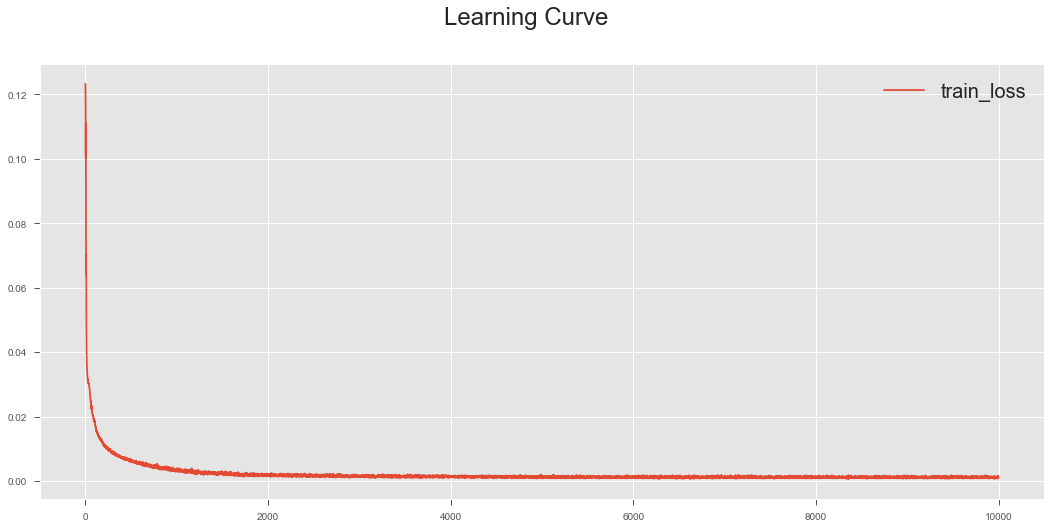

In [293]:
plt.plot(history.history['loss'], label='train_loss')
plt.legend(fontsize=20)
plt.suptitle('Learning Curve', fontsize=24)
plt.show()

In [294]:
predicted_sales = regressor.predict(X_test)
train_fit_sales = regressor.predict(X_train)

In [295]:
predicted_sales = sc.inverse_transform(predicted_sales)
predicted_sales = pd.DataFrame(data=predicted_sales)
predicted_sales.columns = dataset_forLSTM_pivot.columns

In [296]:
train_fit_sales = sc.inverse_transform(train_fit_sales)
train_fit_sales = pd.DataFrame(data=train_fit_sales)
train_fit_sales.columns = dataset_forLSTM_pivot.columns

In [297]:
train_observed_sales = dataset_forLSTM_pivot.iloc[maxlen:train_test_row + maxlen,:]
test_observed_sales = dataset_forLSTM_pivot.iloc[train_test_row + maxlen:,:]

In [298]:
predicted_sales_df = pd.concat([train_fit_sales, predicted_sales])
predicted_sales_df.index = dataset_forLSTM_pivot.iloc[maxlen:,:].index
predicted_sales_df = predicted_sales_df.stack()
predicted_sales_df = predicted_sales_df.reset_index()
predicted_sales_df.rename(columns={'weeklySales': 'predict'}, inplace=True)
predicted_sales_df.head()

,Date,id,predict
0,2010-03-05,10_1,36664.945312
1,2010-03-05,10_10,49655.261719
2,2010-03-05,10_11,32179.425781
3,2010-03-05,10_12,11025.955078
4,2010-03-05,10_13,70080.343750


In [299]:
actual_sales_df = pd.concat([train_observed_sales, test_observed_sales])
actual_sales_df.index = dataset_forLSTM_pivot.iloc[maxlen:,:].index
actual_sales_df = actual_sales_df.stack()
actual_sales_df = actual_sales_df.reset_index()
actual_sales_df.rename(columns={'weeklySales': 'actual'}, inplace=True)

In [300]:
Holiday = dataset_forML.iloc[:,2:5]
Holiday = Holiday.groupby(['Date']).mean()
Holiday = Holiday.iloc[:,1:2]
Holiday = Holiday.reset_index()

df = pd.merge(actual_sales_df, predicted_sales_df, on=['Date', 'id'])
df = pd.merge(df, Holiday, on='Date')
weight = np.where(df['isHoliday']==0, 1, 5)

df = pd.DataFrame({"Date": df['Date'],
                   "id": df['id'],
                   "Weight": weight,
                   "actual":df['actual'],
                  "predict":df['predict']})

df['Derived'] = df['Weight']*abs(df['actual']-df['predict'])
df.head()

,Date,Weight,actual,id,predict,Derived
0,2010-03-05,1,36572.44,10_1,36664.945312,92.505312
1,2010-03-05,1,49892.15,10_10,49655.261719,236.888281
2,2010-03-05,1,31934.99,10_11,32179.425781,244.435781
3,2010-03-05,1,11033.07,10_12,11025.955078,7.114922
4,2010-03-05,1,70279.43,10_13,70080.343750,199.086250


In [301]:
#split df for checking WMAE on validation data
split_date = list(dataset_forLSTM_pivot.index)[train_test_row + maxlen-1]
test_df = df.loc[df['Date'] > split_date]
test_df.head()

,Date,Weight,actual,id,predict,Derived
369741,2012-04-20,1,26759.76,10_1,77025.140625,50265.380625
369742,2012-04-20,1,44237.82,10_10,48038.992188,3801.172188
369743,2012-04-20,1,31777.82,10_11,33581.613281,1803.793281
369744,2012-04-20,1,10625.64,10_12,9485.969727,1139.670273
369745,2012-04-20,1,61133.50,10_13,60765.894531,367.605469


In [302]:
# WMAE on validation data
WMAE = sum(test_df['Derived']) / sum(test_df['Weight'])
WMAE

# 1527 maxlen = 4, units = 200, 200, 200 . epochs=10,000, batch_size = 512, verbose = 1

1526.525573695917

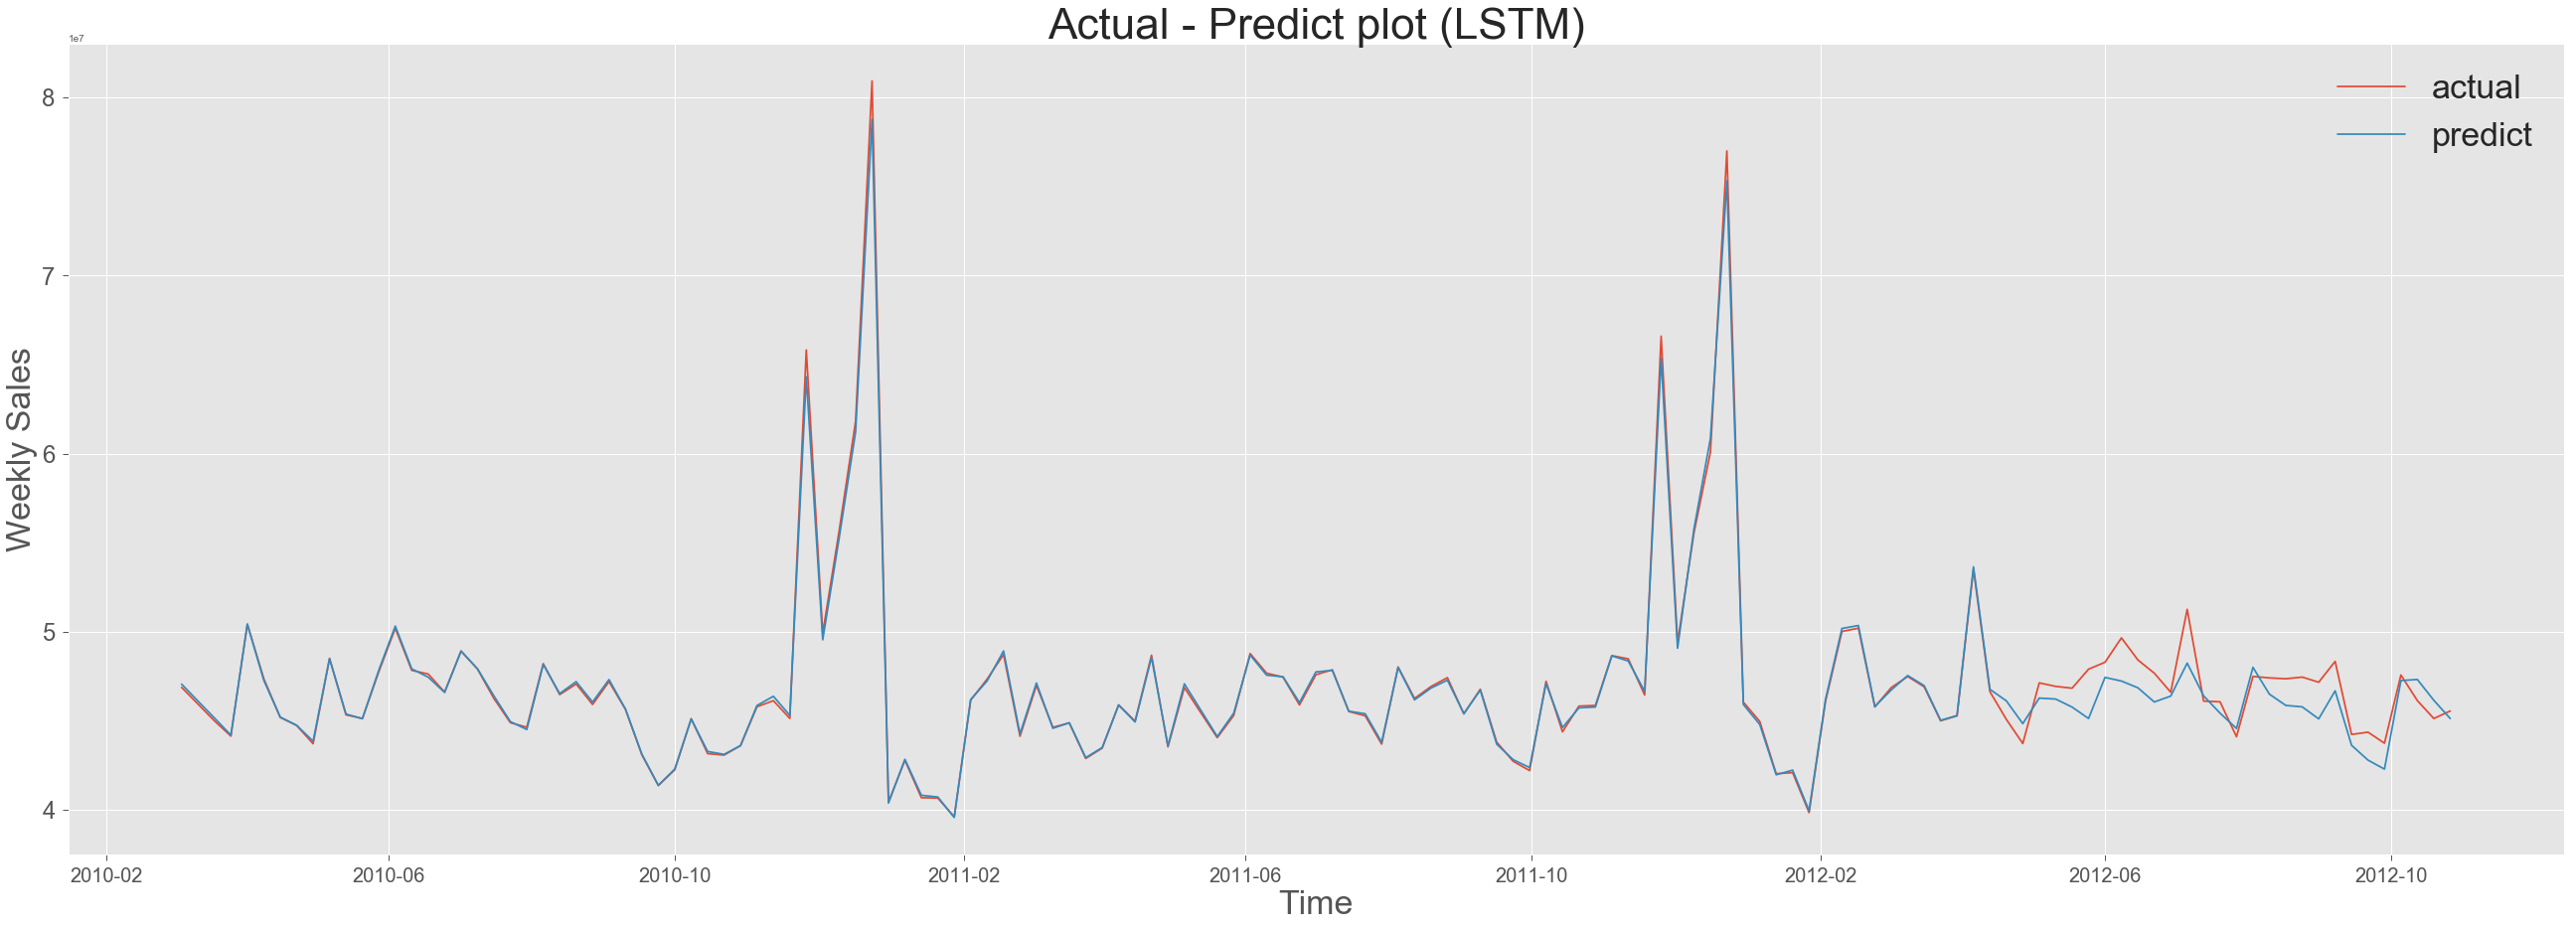

In [358]:
merge_ts = df.loc[:,['Date','actual','predict']]
merge_ts = merge_ts.groupby('Date')['actual', 'predict'].sum().reset_index()
fig, ax = plt.subplots(figsize=(45,15))
ax.plot(merge_ts['Date'], merge_ts['actual'])
ax.plot(merge_ts['Date'], merge_ts['predict'])
ax.set_title('Actual - Predict plot (LSTM)', fontsize=44)
ax.legend(fontsize = 34)
ax.set_xlabel('Time',fontsize = 34)
ax.set_ylabel('Weekly Sales',fontsize = 34)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=24)
#plt.show()

### for submission to Kaggle  (LSTM)

In [304]:
test_dataset_date = test_dataset_forML.reset_index()
test_dataset_date_index = test_dataset_date.groupby(['Date']).mean()
test_dataset_date = test_dataset_date.Date.unique()

In [305]:
test_dataset_date = len(test_dataset_date)

In [306]:

f = dataset_forLSTM_set_scaled[:,0]
input_data_LSTM = f[length_of_sequences-maxlen: length_of_sequences + 1]
input_data_LSTM3 = np.array(input_data_LSTM)


for j in range(1, n_features):
    f = dataset_forLSTM_set_scaled[:,j]#dataset_forLSTM_pivot.iloc[:,j].values
    input_data_LSTM = f[length_of_sequences-maxlen: length_of_sequences + 1]
    input_data_LSTM2 = np.array(input_data_LSTM)
    input_data_LSTM3 = np.dstack([input_data_LSTM3, input_data_LSTM2])



In [307]:
predicted_submission_sales = regressor.predict(input_data_LSTM3)
predicted_submission_sales_save = predicted_submission_sales

In [308]:
# After forecasting one step ahead sales, combined the forecast with the input to forecast next step ahead.

for j in range(1, test_dataset_date):
    dataset_forLSTM_set_scaled = np.vstack([dataset_forLSTM_set_scaled, predicted_submission_sales])
    length_of_sequences = len(dataset_forLSTM_set_scaled)
    f = dataset_forLSTM_set_scaled[:,0]
    input_data_LSTM = f[length_of_sequences-maxlen: length_of_sequences + 1]
    input_data_LSTM3 = np.array(input_data_LSTM)
    for j in range(1, n_features):
        f = dataset_forLSTM_set_scaled[:,j]#dataset_forLSTM_pivot.iloc[:,j].values
        input_data_LSTM = f[length_of_sequences-maxlen: length_of_sequences + 1]
        input_data_LSTM2 = np.array(input_data_LSTM)
        input_data_LSTM3 = np.dstack([input_data_LSTM3, input_data_LSTM2])
    predicted_submission_sales = regressor.predict(input_data_LSTM3)
    predicted_submission_sales_save = np.vstack([predicted_submission_sales_save, predicted_submission_sales])

In [309]:
predicted_submission_sales = sc.inverse_transform(predicted_submission_sales_save)
predicted_submission_sales = pd.DataFrame(data=predicted_submission_sales)
predicted_submission_sales.columns = dataset_forLSTM_pivot.columns

predicted_submission_sales.index = test_dataset_date_index.index
predicted_submission_sales_df = predicted_submission_sales.stack()
predicted_submission_sales_df = predicted_submission_sales_df.reset_index()
predicted_submission_sales_df.rename(columns={'weeklySales': 'predict'}, inplace=True)

In [310]:
predicted_submission_sales_df['Date'] = predicted_submission_sales_df['Date'].astype('str')
predicted_submission_sales_df['id_update'] = predicted_submission_sales_df['id'].str.cat(predicted_submission_sales_df['Date'], sep='_')

In [311]:
submitfile = pd.DataFrame({"id": predicted_submission_sales_df['id_update'],
                  "Weekly_Sales":predicted_submission_sales_df['predict']})
sampleSubmission = pd.read_csv("data/sampleSubmission.csv",sep=',', header=0)
submitfile = pd.merge(sampleSubmission, submitfile, left_on='Id', right_on='id', how='left')
submitfile = pd.DataFrame({"Id": submitfile['Id'],
                  "Weekly_Sales":submitfile['Weekly_Sales_y']})

submitfile.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,35995.839844
1,1_1_2012-11-09,18993.322266
2,1_1_2012-11-16,19349.375000
3,1_1_2012-11-23,19851.435547
4,1_1_2012-11-30,24685.246094


In [312]:
submitfile = submitfile.fillna(0)
submitfile.to_csv('Submission.csv',index=False)